# Credits

* Author : **Aurelio Murolo**
* Exam : Information Retrieval
* Professor : Antonio Maria Rinaldi
* a.a 2024/2025 - Univeristy of Naples Federico II

# Importing Moudules

In [1]:
# Exectuion time of the Colab
import time
start_time = time.time()

In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy import stats
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator


import librosa
from IPython.display import Audio
import librosa.display
import IPython.display as ipd

import os
import json
from datetime import datetime

# Model
import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
from torchaudio import transforms as T
import torchaudio.functional as f

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

!pip install -qq torchmetrics
from torchmetrics.classification import Accuracy

# Control Bar
!pip install -q tqdm
from tqdm.auto import tqdm

# Colab
from google.colab import files
from google.colab import output

# API
import gradio as gr
from typing import Tuple, List, Dict, Any

# warnings
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 26.6 MB/s eta 0:00:00


# Code Reproducibility

In according to the official documentation about [Reproducibility](https://pytorch.org/docs/stable/notes/randomness.html):

> As long as `torch.manual_seed()` is set to a constant at the beginning of an application and all **other sources of nondeterminism** have been eliminated, the same series of random numbers will be generated each time the application is run in the same environment.

The other sources of nondeterminism include both the seeds of other libraries and the intrinsical randomness of the algorithms used by Pytorch for its operations.

Although a good reproducibility may cause a decrese both in performances and speed, it gurantees the optimal condition for the experimentations, Galileo Galilei *docet* . In order to decrees the non - deterministic behaviour we can run the following line of code.





In [3]:
seed = 42

# Torch
torch.manual_seed(seed)  # Seed for both CPU and GPU
torch.cuda.manual_seed(seed)  # Seed for GPU random number generation
torch.cuda.manual_seed_all(seed)  # For multi-GPU

torch.backends.cudnn.benchmark = True  # Deterministically select an algorithm
torch.backends.cudnn.deterministic = True # if only nondeterministic algorithms are available they will throw a RuntimeError when called
torch.Generator().manual_seed(seed)  # Seed for batch shuffling

# Numpy
np.random.seed(seed)

# Python
random.seed(seed)

You can find the full list of the normally-nondeterministic operations that will act deterministically when `torch.backends.cudnn.deterministic = True` at the following [link](https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html#torch.use_deterministic_algorithms) .

In the end it's important to underline that it sufficient to call all the above functions only once at the beginning of the script, especially on a Jupyter Notebook like this where sometimes there are some "mis-comunication" among the cell of code. Anyway as you will see i still called them toI do it to avoid any possible problems.

# Audio MNIST Dataset


> AudioMNIST dataset2 consists of 30,000 audio recordings (amounting to a grand total of approx. 9.5 h of recorded speech) of spoken digits (0–9) in English with 50 repetitions per digit for each of the 60 different speakers. Recordings were collected in quiet offices with a RØDE NT-USB microphone as mono channel signal at a sampling frequency of 48 kHz and were saved in 16 bit integer format. In addition to audio recordings, meta information including age (range: 22–61 years), sex (12 female/48 male), origin and accent of all speakers were collected as well.




In [4]:
!git clone https://github.com/soerenab/AudioMNIST.git

Cloning into 'AudioMNIST'...
remote: Enumerating objects: 30137, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 30137 (delta 9), reused 4 (delta 1), pack-reused 30119 (from 1)
Receiving objects: 100% (30137/30137), 944.54 MiB | 16.99 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Updating files: 100% (30018/30018), done.


## Helper Functions

* **Metadata EDA**

In [5]:
def AudioMNIST_metadata_EDA(DATASET_PATH = '/content/audioMNIST_meta.csv'):
    """
    Performs Exploratory Data Analysis (EDA) on AudioMNIST metadata with outlier imputation.

    This function creates a comprehensive 2x2 subplot visualization analyzing:
    1. Speaker Age Distribution (histogram with KDE)
    2. Speaker Gender Distribution (pie chart)
    3. Speaker Accent Distribution (horizontal bar chart)
    4. Speaker Nativity Distribution (pie chart)

    Data preprocessing includes:
    - Outlier detection and imputation: Age outliers (like 1234) are replaced with median age
    - This approach preserves the sample size while maintaining a realistic age distribution

    Parameters:
    -----------
    DATASET_PATH : str, default='/content/audioMNIST_meta.csv'
        Path to the AudioMNIST metadata CSV file

    Returns:
    --------
    None
        Displays the visualization and prints detailed statistics

    Color Scheme:
    ------------
    Uses a blue-green palette throughout all visualizations for consistency
    """

    # Read the CSV file
    df = pd.read_csv('audioMNIST_meta.csv')

    # Step 1: Identify outliers (ages that seem unrealistic, like 1234)
    realistic_ages = df[df['age'] < 100]['age']  # Assuming ages over 100 are outliers
    # Step 2: Calculate median of realistic ages (excluding outliers)
    median_age = realistic_ages.median()

    # Step 3: Replace outliers with median age
    df_clean = df.copy()
    df_clean.loc[df_clean['age'] >= 100, 'age'] = median_age

    print(f"Data preprocessing completed:")
    print(f"- Outliers detected: {len(df[df['age'] >= 100])} records")
    print(f"- Outliers replaced with median age: {median_age:.1f} years")
    print(f"- Total records retained: {len(df_clean)}")
    print("-" * 50)

    # Set up the plotting style
    plt.style.use('default')
    # blue-green palette
    blue_green_palette = ['#1f77b4', '#2ca02c', '#17becf', '#2ca25f', '#6baed6', '#74c476', '#08519c', '#238b45']
    sns.set_palette(blue_green_palette)

    # Create a 2x2 subplot
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('AudioMNIST Dataset Analysis', fontsize=16, fontweight='bold')

    # 1. Speaker Age Distribution (top-left)
    sns.histplot(data=df_clean, x='age', bins=15, kde=True, ax=axes[0,0])
    axes[0,0].set_title('Speaker Age Distribution', fontweight='bold')
    axes[0,0].set_xlabel('Age')
    axes[0,0].set_ylabel('Count')
    axes[0,0].grid(True, alpha=0.3)

    # Add some statistics
    mean_age = df_clean['age'].mean()
    median_age_clean = df_clean['age'].median()
    axes[0,0].axvline(mean_age, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_age:.1f}')
    axes[0,0].axvline(median_age_clean, color='black', linestyle='--', alpha=0.7, label=f'Median: {median_age_clean:.1f}')
    axes[0,0].legend()

    # 2. Speaker Gender Distribution (top-right)
    gender_counts = df_clean['gender'].value_counts()
    colors_gender = ['#1f77b4', '#2ca02c']  # Blue and green
    wedges, texts, autotexts = axes[0,1].pie(gender_counts.values, labels=gender_counts.index,
                                             autopct='%1.1f%%', colors=colors_gender, startangle=90)
    axes[0,1].set_title('Speaker Gender Distribution', fontweight='bold')

    # Make percentage text more readable
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    # 3. Speaker Accent Distribution (bottom-left)
    accent_counts = df_clean['accent'].value_counts()
    plt.sca(axes[1,0])
    sns.countplot(data=df_clean, y='accent', order=accent_counts.index, ax=axes[1,0])
    axes[1,0].set_title('Speaker Accent Distribution', fontweight='bold')
    axes[1,0].set_xlabel('Count')
    axes[1,0].set_ylabel('Accent')
    axes[1,0].grid(True, alpha=0.3, axis='x')

    # Add count labels on bars
    for i, (accent, count) in enumerate(accent_counts.items()):
        axes[1,0].text(count + 0.1, i, str(count), va='center', fontweight='bold')

    # 4. Speaker Nativity Distribution (bottom-right)
    nativity_counts = df_clean['native speaker'].value_counts()
    colors_nativity = ['#17becf', '#74c476']  # Light blue and light green
    # Create proper labels based on the actual values in the data
    labels = ['Non-native' if val == 'no' else 'Native' for val in nativity_counts.index]
    wedges, texts, autotexts = axes[1,1].pie(nativity_counts.values,
                                             labels=labels,
                                             autopct='%1.1f%%', colors=colors_nativity, startangle=90)
    axes[1,1].set_title('Speaker Nativity Distribution', fontweight='bold')

    # Make percentage text more readable
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    # Adjust layout to prevent overlapping
    filename = f"AudioMNIST_EDA.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight', format='png')
    print(f"Plot saved as: {filename}")
    plt.tight_layout()
    plt.show()

    # Print additional stats
    print("AudioMNIST Dataset Insights:")
    print("=" * 40)
    print(f"Total number of speakers: {len(df_clean)}")
    print(f"Age statistics:")
    print(f"  - Mean age: {df_clean['age'].mean():.1f} years")
    print(f"  - Median age: {df_clean['age'].median():.1f} years")
    print(f"  - Age range: {df_clean['age'].min()}-{df_clean['age'].max()} years")
    print(f"  - Standard deviation: {df_clean['age'].std():.1f} years")

    print(f"\nGender distribution:")
    for gender, count in gender_counts.items():
        print(f"  - {gender.capitalize()}: {count} ({count/len(df_clean)*100:.1f}%)")

    print(f"\nNative speaker distribution:")
    for native, count in nativity_counts.items():
        status = "Native" if native == 'yes' else "Non-native"
        print(f"  - {status}: {count} ({count/len(df_clean)*100:.1f}%)")

    print(f"\nTop 5 accents:")
    for i, (accent, count) in enumerate(accent_counts.head().items()):
        print(f"  {i+1}. {accent.capitalize()}: {count} speakers ({count/len(df_clean)*100:.1f}%)")

In [6]:
def AudioMNIST_metadata_EDA_by_gender(DATASET_PATH = '/content/audioMNIST_meta.csv'):
    """
    Performs Exploratory Data Analysis (EDA) on AudioMNIST metadata separated by gender.

    This function creates two comprehensive 2x2 subplot visualizations, one for each gender:
    - First subplot: Male speakers analysis
    - Second subplot: Female speakers analysis

    Each subplot analyzes:
    1. Speaker Age Distribution (histogram with KDE)
    2. Speaker Gender Distribution (pie chart showing only the current gender)
    3. Speaker Accent Distribution (horizontal bar chart)
    4. Speaker Nativity Distribution (pie chart)

    Data preprocessing includes:
    - Outlier detection and imputation: Age outliers (like 1234) are replaced with median age
    - Gender-based filtering for separate analysis

    Parameters:
    -----------
    DATASET_PATH : str, default='/content/audioMNIST_meta.csv'
        Path to the AudioMNIST metadata CSV file

    Returns:
    --------
    None
        Displays two separate visualizations and prints detailed statistics for each gender

    Color Scheme:
    ------------
    Uses a blue-green palette for consistency across visualizations
    """

    # Read the CSV file
    df = pd.read_csv('audioMNIST_meta.csv')

    # Data cleaning with outlier imputation
    realistic_ages = df[df['age'] < 100]['age']
    median_age = realistic_ages.median()

    df_clean = df.copy()
    df_clean.loc[df_clean['age'] >= 100, 'age'] = median_age

    print(f"Data preprocessing completed:")
    print(f"- Outliers detected: {len(df[df['age'] >= 100])} records")
    print(f"- Outliers replaced with median age: {median_age:.1f} years")
    print(f"- Total records retained: {len(df_clean)}")
    print("-" * 60)

    # Set up the plotting style
    plt.style.use('default')
    blue_green_palette = ['#1f77b4', '#2ca02c', '#17becf', '#2ca25f', '#6baed6', '#74c476', '#08519c', '#238b45']
    sns.set_palette(blue_green_palette)

    # Get unique genders and create separate analyses
    genders = df_clean['gender'].unique()

    for gender in genders:
        # Filter data for current gender
        df_gender = df_clean[df_clean['gender'] == gender]

        # Create a 2x2 subplot for current gender
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Set main title based on gender
        if gender.lower() == 'male':
            main_title = 'AudioMNIST Dataset Analysis - Male Speakers'
        else:
            main_title = 'AudioMNIST Dataset Analysis - Female Speakers'

        fig.suptitle(main_title, fontsize=16, fontweight='bold')

        # 1. Speaker Age Distribution (top-left)
        sns.histplot(data=df_gender, x='age', bins=15, kde=True, ax=axes[0,0])
        axes[0,0].set_title('Speaker Age Distribution', fontweight='bold')
        axes[0,0].set_xlabel('Age')
        axes[0,0].set_ylabel('Count')
        axes[0,0].grid(True, alpha=0.3)

        # Add statistics
        mean_age = df_gender['age'].mean()
        median_age_clean = df_gender['age'].median()
        axes[0,0].axvline(mean_age, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_age:.1f}')
        axes[0,0].axvline(median_age_clean, color='black', linestyle='--', alpha=0.7, label=f'Median: {median_age_clean:.1f}')
        axes[0,0].legend()

        # 2. Speaker Gender Distribution (top-right) - shows only current gender
        axes[0,1].pie([100], labels=[f'{gender.capitalize()}'], autopct='%1.1f%%',
                      colors=['#1f77b4'], startangle=90)
        axes[0,1].set_title('Gender Distribution', fontweight='bold')

        # 3. Speaker Accent Distribution (bottom-left)
        accent_counts = df_gender['accent'].value_counts()
        plt.sca(axes[1,0])
        sns.countplot(data=df_gender, y='accent', order=accent_counts.index, ax=axes[1,0])
        axes[1,0].set_title('Accent Distribution', fontweight='bold')
        axes[1,0].set_xlabel('Count')
        axes[1,0].set_ylabel('Accent')
        axes[1,0].grid(True, alpha=0.3, axis='x')

        # Add count labels on bars
        for i, (accent, count) in enumerate(accent_counts.items()):
            axes[1,0].text(count + 0.1, i, str(count), va='center', fontweight='bold')

        # 4. Speaker Nativity Distribution (bottom-right)
        nativity_counts = df_gender['native speaker'].value_counts()
        colors_nativity = ['#17becf', '#74c476']
        labels = ['Non-native' if val == 'no' else 'Native' for val in nativity_counts.index]
        wedges, texts, autotexts = axes[1,1].pie(nativity_counts.values,
                                                 labels=labels,
                                                 autopct='%1.1f%%', colors=colors_nativity[:len(nativity_counts)],
                                                 startangle=90)
        axes[1,1].set_title('Native Speaker Distribution', fontweight='bold')

        # Make percentage text more readable
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')

        # Save the plot in high quality
        filename = f"AudioMNIST_EDA_{gender.lower()}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight', format='png')
        print(f"Plot saved as: {filename}")
        # Adjust layout
        plt.tight_layout()
        plt.show()

        # Print statistics for current gender
        print(f"\nAudioMNIST Statistics - {gender.upper()}:")
        print("=" * 50)
        print(f"Total number of {gender.lower()} speakers: {len(df_gender)}")
        print(f"Age statistics:")
        print(f"  - Average age: {df_gender['age'].mean():.1f} years")
        print(f"  - Median age: {df_gender['age'].median():.1f} years")
        print(f"  - Age range: {df_gender['age'].min()}-{df_gender['age'].max()} years")
        print(f"  - Standard deviation: {df_gender['age'].std():.1f} years")

        print(f"\nNative speaker distribution:")
        for native, count in nativity_counts.items():
            status = "Native" if native == 'yes' else "Non-native"
            print(f"  - {status}: {count} ({count/len(df_gender)*100:.1f}%)")

        print(f"\nTop 5 accents:")
        for i, (accent, count) in enumerate(accent_counts.head().items()):
            print(f"  {i+1}. {accent.capitalize()}: {count} speakers ({count/len(df_gender)*100:.1f}%)")

        print("-" * 60)

    # Summary comparison
    print(f"\nCOMPARATIVE SUMMARY:")
    print("=" * 50)
    male_count = len(df_clean[df_clean['gender'] == 'male'])
    female_count = len(df_clean[df_clean['gender'] == 'female'])
    total_count = len(df_clean)

    print(f"Total male speakers: {male_count} ({male_count/total_count*100:.1f}%)")
    print(f"Total female speakers: {female_count} ({female_count/total_count*100:.1f}%)")
    print(f"Overall total: {total_count}")

* **WaveForm EDA**

In [7]:
def WaveForm_EDA(AUDIO_PATH_LIST: list, trimmed_sig: bool = False):
    """
    Performs Exploratory Data Analysis (EDA) on audio waveform durations and sample counts.

    This function loads a list of audio files, calculates their duration and
    number of samples, and then visualizes the distributions of these metrics
    using histograms. It also prints descriptive statistics such as mean, median,
    minimum, and maximum values. An optional `trimmed_sig` parameter allows for
    the removal of leading and trailing silence from the audio before analysis.

    Args:
      AUDIO_PATH_LIST (list): A list of file paths to the audio files.
      trimmed_sig (bool, optional): If True, audio silence is trimmed before
                                    calculating duration and samples. Defaults to False.

    Returns:
      tuple: A tuple containing two lists:
             - wave_forms_duration (list): The duration in seconds for each audio file.
             - wave_forms_n_samples (list): The number of samples for each audio file.
    """
    wave_forms_duration = []
    wave_forms_n_samples = []

    for audio_path in AUDIO_PATH_LIST:
        # Load audio file without resampling
        y, sr = librosa.load(audio_path, sr=None)

        if trimmed_sig:
            # Trim silence from the audio
            y, _ = librosa.effects.trim(y, top_db=20)

        # Calculate duration and number of samples
        duration = librosa.get_duration(y=y, sr=sr)
        n_samples = len(y)

        wave_forms_duration.append(duration)
        wave_forms_n_samples.append(n_samples)

    # Distribution of Durations
    plt.figure(figsize=(10, 6))
    sns.histplot(wave_forms_duration, bins=20, kde=True)
    plt.title('Distribution of Audio Waveform Durations')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Distribution of Number of Samples
    plt.figure(figsize=(10, 6))
    sns.histplot(wave_forms_n_samples, bins=20, kde=True)
    plt.title('Distribution of Number of Samples per Audio Waveform')
    plt.xlabel('Number of Samples')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Basic statistics for Duration
    print(f"\n--- Duration Statistics ---")
    # Print sampling rate only if it was consistent or if you want to show the first one encountered
    print(f"Sampling Rate (Hz): {sr}")
    print(f"Number of audio files: {len(wave_forms_duration)}")
    print(f"Minimum duration: {np.min(wave_forms_duration):.2f} seconds")
    print(f"Maximum duration: {np.max(wave_forms_duration):.2f} seconds")
    print(f"Average duration: {np.mean(wave_forms_duration):.2f} seconds")
    print(f"Median duration: {np.median(wave_forms_duration):.2f} seconds")
    print(f"Standard deviation of duration: {np.std(wave_forms_duration):.2f} seconds")

    # Basic statistics for Number of Samples
    print(f"\n--- Number of Samples Statistics ---")
    print(f"Minimum number of samples: {np.min(wave_forms_n_samples):.0f}")
    print(f"Maximum number of samples: {np.max(wave_forms_n_samples):.0f}")
    print(f"Average number of samples: {np.mean(wave_forms_n_samples):.0f}")
    print(f"Median number of samples: {np.median(wave_forms_n_samples):.0f}")
    print(f"Standard deviation of number of samples: {np.std(wave_forms_n_samples):.0f}")

    return wave_forms_duration, wave_forms_n_samples

##  Audio Metadata

In [8]:
# Load metadata
with open("/content/AudioMNIST/data/audioMNIST_meta.txt", "r") as f:
    metadata = json.load(f)

# Data Normalization
for speaker in metadata:

    # Age
    metadata[speaker]['age'] = int(metadata[speaker]['age'])
    # accent
    metadata[speaker]['accent'] = str(metadata[speaker]['accent']).lower()
    # gender
    metadata[speaker]['gender'] = str(metadata[speaker]['gender']).lower()
    # native speaker
    metadata[speaker]['native speaker'] = str(metadata[speaker]['native speaker']).lower()
    # recordingdate
    metadata[speaker]['recordingdate'] = datetime.strptime(str(metadata[speaker]['recordingdate']), "%y-%m-%d-%H-%M-%S")
    # recordingroom
    metadata[speaker]['recordingroom'] = str(metadata[speaker]['recordingroom']).lower()

# Convert to DataFrame
df_meta = pd.DataFrame.from_dict(metadata, orient='index')

# Reset index and rename for clarity
df_meta.reset_index(inplace=True)
df_meta.rename(columns={'index': 'speaker_id'}, inplace=True)

In [9]:
#df_meta

In [10]:
# Download metadata dataset
df_meta.to_csv('audioMNIST_meta.csv', index=False)

### Metadata EDA

Now one can easily plot the desired graph to get some insights from data, in particular there will be showed:
1. Speaker Age distribution ;
2. Speaker Gender ditribution ;
3. Speaker Accent distribution ;
4. Speaker Nativity distribution .

Such analysis will be also performed indipendently for both genders.

Data preprocessing completed:
- Outliers detected: 1 records
- Outliers replaced with median age: 27.0 years
- Total records retained: 60
--------------------------------------------------
Plot saved as: AudioMNIST_EDA.png


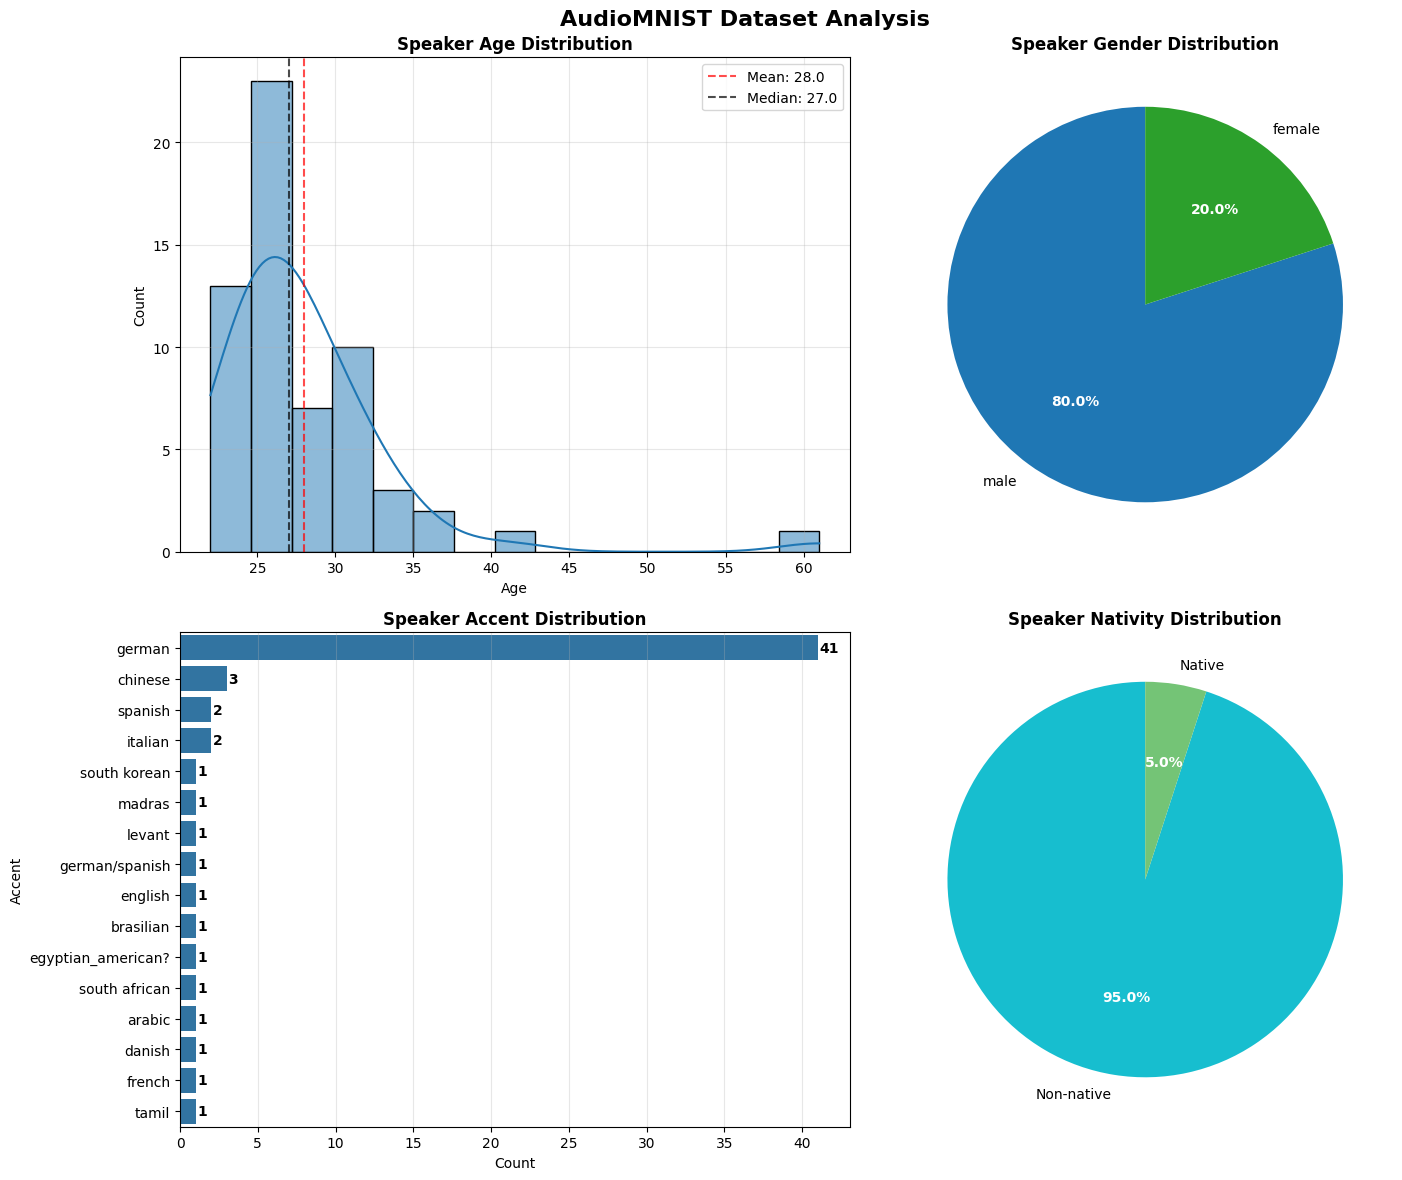

AudioMNIST Dataset Insights:
Total number of speakers: 60
Age statistics:
  - Mean age: 28.0 years
  - Median age: 27.0 years
  - Age range: 22-61 years
  - Standard deviation: 5.8 years

Gender distribution:
  - Male: 48 (80.0%)
  - Female: 12 (20.0%)

Native speaker distribution:
  - Non-native: 57 (95.0%)
  - Native: 3 (5.0%)

Top 5 accents:
  1. German: 41 speakers (68.3%)
  2. Chinese: 3 speakers (5.0%)
  3. Spanish: 2 speakers (3.3%)
  4. Italian: 2 speakers (3.3%)
  5. South korean: 1 speakers (1.7%)


In [11]:
AudioMNIST_metadata_EDA()

Data preprocessing completed:
- Outliers detected: 1 records
- Outliers replaced with median age: 27.0 years
- Total records retained: 60
------------------------------------------------------------
Plot saved as: AudioMNIST_EDA_male.png


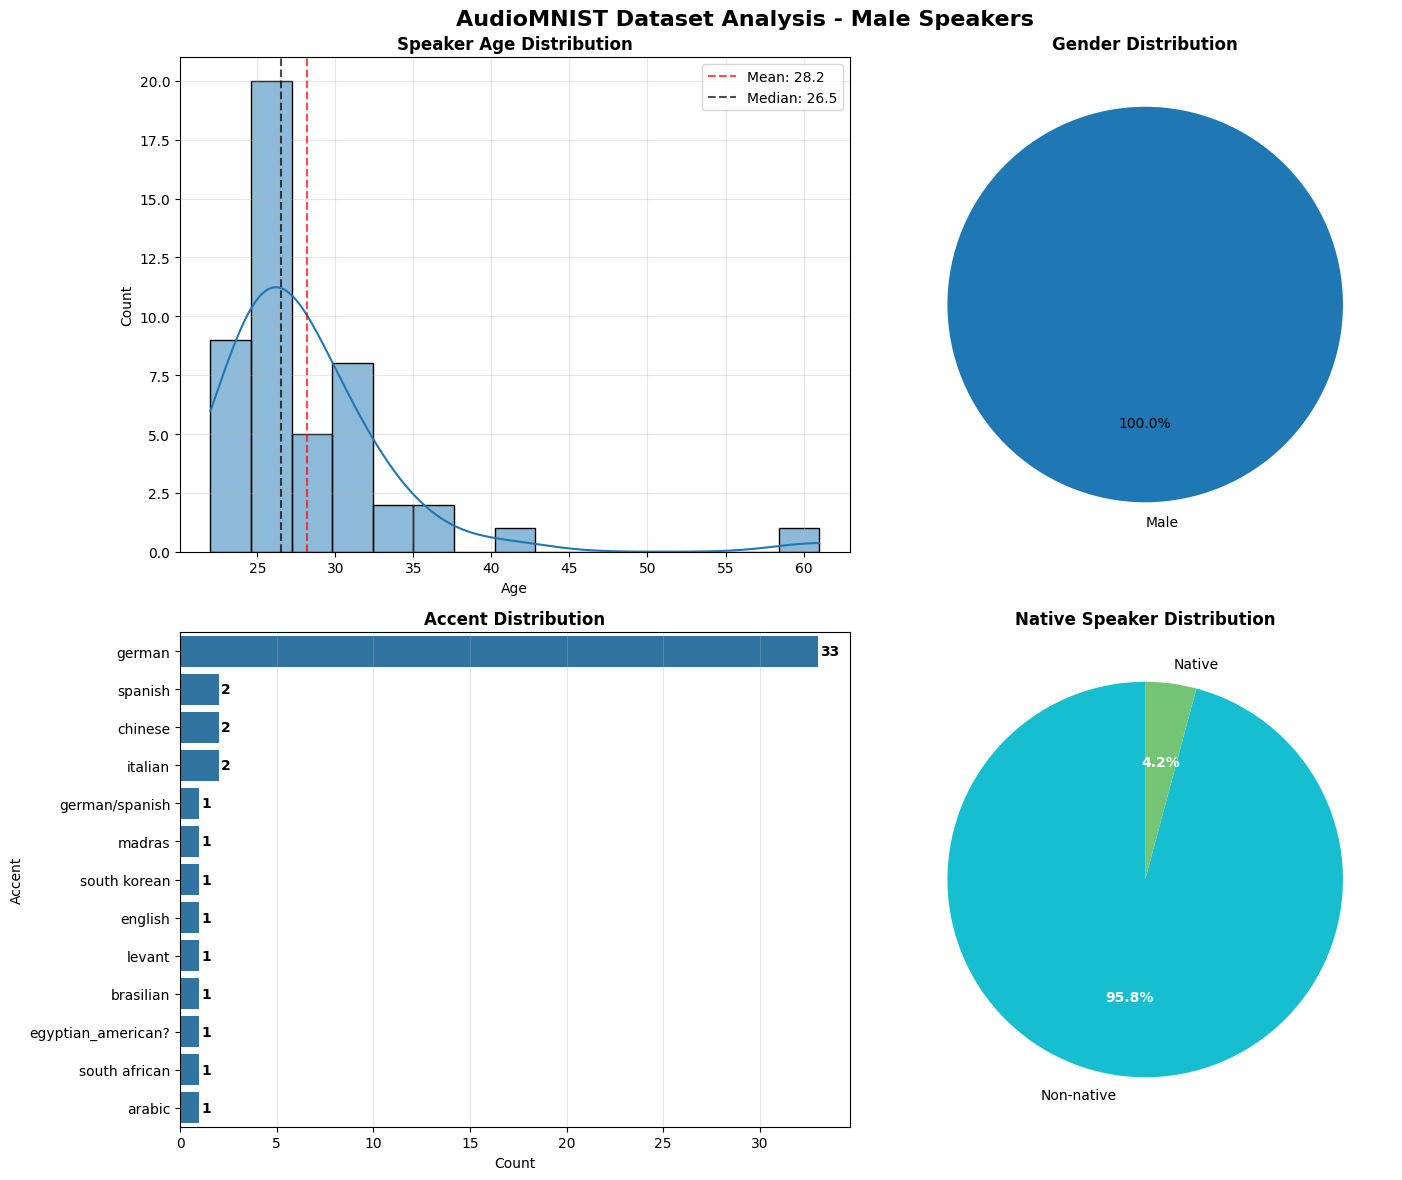


AudioMNIST Statistics - MALE:
Total number of male speakers: 48
Age statistics:
  - Average age: 28.2 years
  - Median age: 26.5 years
  - Age range: 22-61 years
  - Standard deviation: 6.2 years

Native speaker distribution:
  - Non-native: 46 (95.8%)
  - Native: 2 (4.2%)

Top 5 accents:
  1. German: 33 speakers (68.8%)
  2. Spanish: 2 speakers (4.2%)
  3. Chinese: 2 speakers (4.2%)
  4. Italian: 2 speakers (4.2%)
  5. German/spanish: 1 speakers (2.1%)
------------------------------------------------------------
Plot saved as: AudioMNIST_EDA_female.png


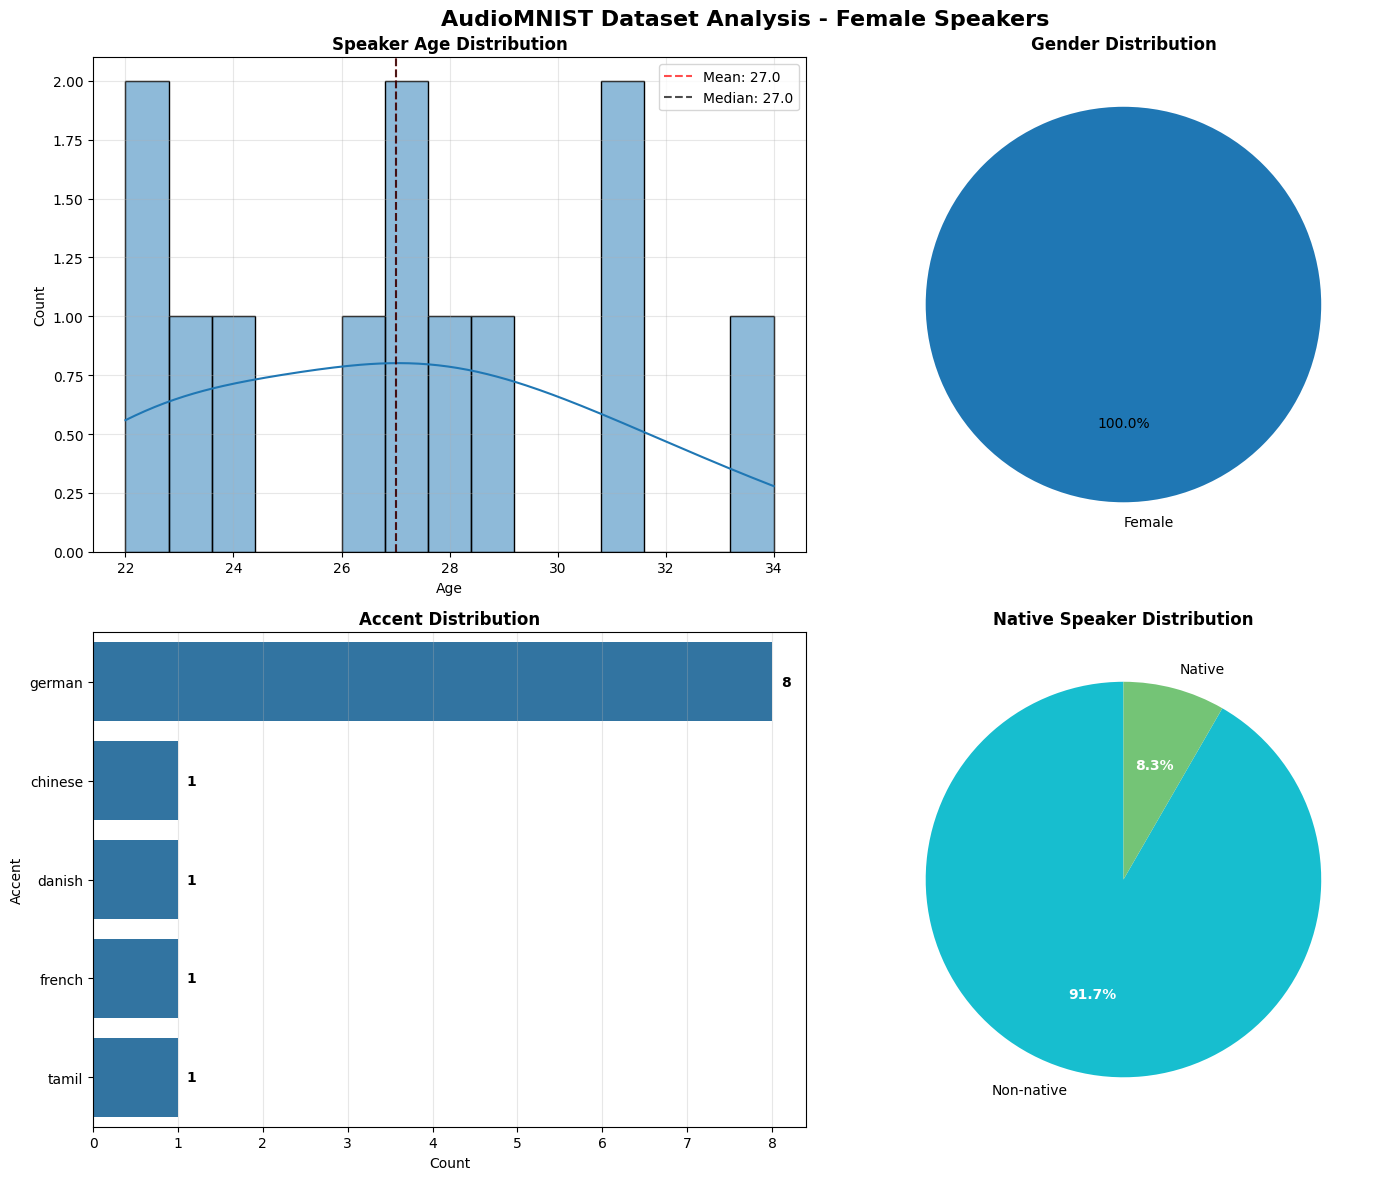


AudioMNIST Statistics - FEMALE:
Total number of female speakers: 12
Age statistics:
  - Average age: 27.0 years
  - Median age: 27.0 years
  - Age range: 22-34 years
  - Standard deviation: 3.8 years

Native speaker distribution:
  - Non-native: 11 (91.7%)
  - Native: 1 (8.3%)

Top 5 accents:
  1. German: 8 speakers (66.7%)
  2. Chinese: 1 speakers (8.3%)
  3. Danish: 1 speakers (8.3%)
  4. French: 1 speakers (8.3%)
  5. Tamil: 1 speakers (8.3%)
------------------------------------------------------------

COMPARATIVE SUMMARY:
Total male speakers: 48 (80.0%)
Total female speakers: 12 (20.0%)
Overall total: 60


In [12]:
AudioMNIST_metadata_EDA_by_gender()

Based on this analysis we can extract some insights:
1. The **female** gender is statistically **under-represented** compared to the male gender, this can very likely reduce the generalization capabilities of a model trained on the gender recognition task ;
2. The **German accent** is excessively **over-represented** compared to the other to such an extent that it is convenient to define a binary variable that identifies whether the accent is German or not.



## Audio MNIST as Pandas DataFrame

In [13]:
wav_list_of_files = os.listdir("/content/AudioMNIST/data")
wav_list_of_files.remove('audioMNIST_meta.txt')
wav_list_of_files.sort()

In [14]:
AudioMNIST_filenames = {'audio_filepath':[], 'digit':[], 'speaker_id':[], 'repetition':[]}
for speaker_id in wav_list_of_files:

  speaker_dir_name = f"/content/AudioMNIST/data/{speaker_id}"
  audio_name_list = os.listdir(speaker_dir_name)

  for audio_name in audio_name_list:
    audio_path = f"/content/AudioMNIST/data/{speaker_id}/{audio_name}"

    digit, speaker_id, repetition = audio_name.split('.')[0].split('_')[0], audio_name.split('.')[0].split('_')[1], audio_name.split('.')[0].split('_')[2]

    AudioMNIST_filenames['audio_filepath'].append(audio_path)
    AudioMNIST_filenames['digit'].append(digit)
    AudioMNIST_filenames['speaker_id'].append(speaker_id)
    AudioMNIST_filenames['repetition'].append(repetition)


In [15]:
audio_df = pd.DataFrame(AudioMNIST_filenames)

In [16]:
df_AudioMNIST = pd.merge(audio_df, df_meta, on = 'speaker_id', how = 'left')

In [17]:
df_AudioMNIST.head(3)

,audio_filepath,digit,speaker_id,repetition,accent,age,gender,native speaker,origin,recordingdate,recordingroom
0,/content/AudioMNIST/data/01/2_01_2.wav,2,01,2,german,30,male,no,"Europe, Germany, Wuerzburg",2017-06-22 11:04:28,kino
1,/content/AudioMNIST/data/01/2_01_15.wav,2,01,15,german,30,male,no,"Europe, Germany, Wuerzburg",2017-06-22 11:04:28,kino
2,/content/AudioMNIST/data/01/1_01_31.wav,1,01,31,german,30,male,no,"Europe, Germany, Wuerzburg",2017-06-22 11:04:28,kino


### Audio WaveForm EDA

In this section the objective is analyze the distribution of the duration of the audio file to estabilish the best approach to to standardize the  size of audios with an appropriate padding / cutting approach :

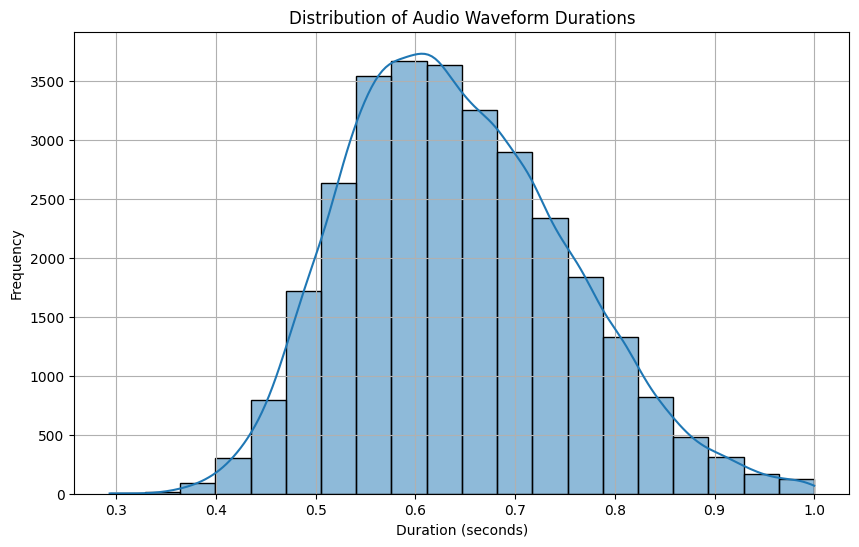

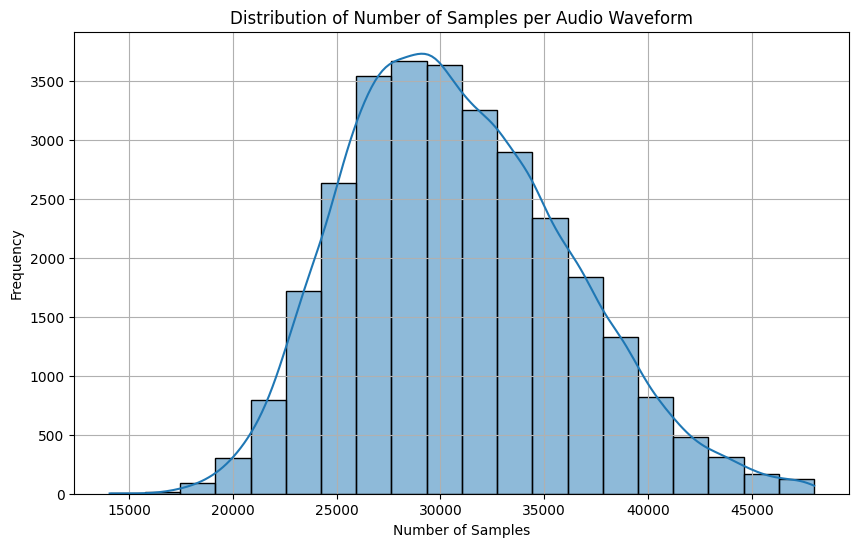


--- Duration Statistics ---
Sampling Rate (Hz): 48000
Number of audio files: 30000
Minimum duration: 0.29 seconds
Maximum duration: 1.00 seconds
Average duration: 0.64 seconds
Median duration: 0.63 seconds
Standard deviation of duration: 0.11 seconds

--- Number of Samples Statistics ---
Minimum number of samples: 14073
Maximum number of samples: 47998
Average number of samples: 30844
Median number of samples: 30336
Standard deviation of number of samples: 5335


In [18]:
duration_list, n_sample_list = WaveForm_EDA(df_AudioMNIST['audio_filepath'].to_list())

## AudioMNIST Dataset Cleaned

Here the final version of the dataset that will be used for the developement of the needed models. The only differences with the  original dataset are:
1. Age outliers (like $1234$) are replaced with median age which is $27$ ;
2. The accent now consist only of a binary variable which indicates wether the accen is German or not.

In [19]:
realistic_ages = df_AudioMNIST[df_AudioMNIST['age'] < 100]['age']  # Assuming ages over 100 are outliers
median_age = realistic_ages.median()

# Replace outliers with median age

AudioMNIST_clean = df_AudioMNIST.copy()
AudioMNIST_clean.loc[AudioMNIST_clean['age'] >= 100, 'age'] = median_age

# Boolean German Accent column
AudioMNIST_clean['is_german_accent'] = AudioMNIST_clean['accent'].apply(lambda x: 'yes' if x == 'german' else 'no')

In [20]:
# Download
AudioMNIST_clean.to_csv('AudioMNIST_clean.csv', index=False)

In [21]:
#AudioMNIST_clean.head()

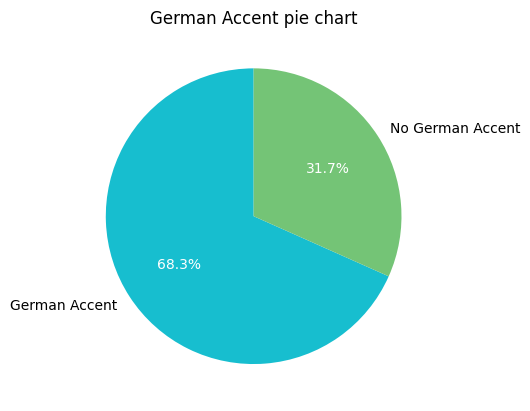

In [22]:
# Pie graph for "is_german_accent"
german_accent_counts = AudioMNIST_clean['is_german_accent'].value_counts()
colors_german_accent = ['#17becf', '#74c476']
labels_german_accent = ['German Accent', 'No German Accent']
wedges_german_accent, texts_german_accent, autotexts_german_accent = plt.pie(german_accent_counts,
                                                                             labels=labels_german_accent,
                                                                             autopct='%1.1f%%',
                                                                             colors=colors_german_accent,
                                                                             startangle=90)
plt.title('German Accent pie chart')


# Make percentage text more readable
for autotext in autotexts_german_accent:
    autotext.set_color('white')

# Audio Feature Extraction

## MFCCs + Delta1 + Delta2

* `n_fft` parameter refers to the **window lenght** used to analyze define the effective frame size. Its value depends mainly on the the sampling rate and the case study. In our case we have to process speech audio so it is relevant to keep in mind both that an average human being can only percive sound variation over the $10\text{ms}$ and that the elementary unit of the speech (phoneme) has a duration of $30/40 \text{ms}$, especially in a controlled enviroment like the laboratories where these audio had been recorded.
This parameter is expressed in terms of number of samples, so :
  * $$\text{nfft} = \text{target duration } \cdot \text{sr}  $$


In [23]:
nfft_lowerbound = 10e-3 * 48_000
nfft_upperbound = 40e-3 * 48_000

print(f"Lower bound: {nfft_lowerbound:.0f} samples")
print(f"Upper bound: {nfft_upperbound:.0f} samples")

Lower bound: 480 samples
Upper bound: 1920 samples


In the cell below you can find how the feature extraction is applied on the audio data using MFCCs and deltas using Librosa.

In [24]:
sr = 48_000           # Sampling Rate
n_fft = 2048          # (~43 ms)
hop_length = 1024     # Overlapping samples(50% di sovrapposizione)
n_mels = 40           # Number of Mel filters
n_mfcc = 13           # Number of MFCCs coeff

# Load
audio_path = AudioMNIST_clean['audio_filepath'][0]
y, sr = librosa.load(audio_path, sr = sr)

# MFCC
mfccs = librosa.feature.mfcc(y = y,
                             sr = sr,
                             n_fft = n_fft,
                             hop_length = hop_length,
                             n_mels = n_mels,
                             n_mfcc = n_mfcc)

# First and second order Delta
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

print('\nMFCC shape: ', mfccs.shape, "(n_mfcc x frames)")
print('Delta shape: ', delta_mfccs.shape)
print('Delta-Delta shape: ', delta2_mfccs.shape)

# Vertical Stack of the features selected. The i-th column is releted to the i-th frame
features_per_frame = np.vstack([mfccs, delta_mfccs, delta2_mfccs])

print(f"Feature dimension per frame (MFCC + Delta + Delta-Delta): {features_per_frame.shape} (3*n_mfcc x frames)")

# Pooling along the frame dimension
audio_embedding = np.mean(features_per_frame, axis=1)
print(f"Pooled feature dimension: {audio_embedding.shape}")


MFCC shape:  (13, 23) (n_mfcc x frames)
Delta shape:  (13, 23)
Delta-Delta shape:  (13, 23)
Feature dimension per frame (MFCC + Delta + Delta-Delta): (39, 23) (3*n_mfcc x frames)
Pooled feature dimension: (39,)


In the *Information Retrieval System* section, there will be defined the same function but using pytorch audio instead of librosa.

## 2D-CNN with Mel-Spectogram Immages as Input


### Helper Functions

In [25]:
def plot_waveform(waveform : torch.Tensor, sr, title = "Waveform", ax = None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

    plt.tight_layout()
    plt.show()


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

    plt.tight_layout()
    plt.show()


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

    plt.tight_layout()
    plt.show()

def plot_training_results(epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plots the training loss, validation loss, training accuracy, and validation accuracy trends.

    Parameters:
    epochs (int): Number of epochs
    train_losses (list): List of training loss values
    val_losses (list): List of validation loss values
    train_accuracies (list): List of training accuracy values
    val_accuracies (list): List of validation accuracy values
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Loss plot
    axes[0].plot(range(epochs), train_losses, label='Train Loss', color='blue')
    axes[0].plot(range(epochs), val_losses, label='Val Loss', color='red')
    axes[0].set_title('Loss Trend')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Accuracy plot
    axes[1].plot(range(epochs), train_accuracies, label='Train Accuracy', color='blue')
    axes[1].plot(range(epochs), val_accuracies, label='Val Accuracy', color='red')
    axes[1].set_title('Accuracy Trend')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


def plot_training_metrics(epochs, train_loss, val_loss, train_acc_digit, train_acc_gender, train_acc_accent, train_avg_acc, val_acc_digit, val_acc_gender, val_acc_accent, val_avg_acc):
    """
    Generates two side-by-side plots to visualize training and validation metrics.

    Args:
        epochs (list): List of epoch indices.
        train_loss (list): List of training loss values.
        val_loss (list): List of validation loss values.
        train_acc_digit (list): List of 'Digit' accuracy for training.
        train_acc_gender (list): List of 'Gender' accuracy for training.
        train_acc_accent (list): List of 'Accent' accuracy for training.
        train_avg_acc (list): List of average accuracy for training.
        val_acc_digit (list): List of 'Digit' accuracy for validation.
        val_acc_gender (list): List of 'Gender' accuracy for validation.
        val_acc_accent (list): List of 'Accent' accuracy for validation.
        val_avg_acc (list): List of average accuracy for validation.
    """

    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Plot 1: Loss Trend
    sns.lineplot(x=epochs, y=train_loss, ax=axes[0], label='Train Loss', marker='o')
    sns.lineplot(x=epochs, y=val_loss, ax=axes[0], label='Validation Loss', marker='x')
    axes[0].set_title('Loss Trend per Epoch')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot 2: Accuracy Trends
    sns.lineplot(x=epochs, y=train_acc_digit, ax=axes[1], label='Train Acc Digit', marker='o', linestyle='--')
    sns.lineplot(x=epochs, y=train_acc_gender, ax=axes[1], label='Train Acc Gender', marker='o', linestyle='--')
    sns.lineplot(x=epochs, y=train_acc_accent, ax=axes[1], label='Train Acc Accent', marker='o', linestyle='--')
    sns.lineplot(x=epochs, y=train_avg_acc, ax=axes[1], label='Train Avg Acc', marker='o', linewidth=2, color='darkblue')

    sns.lineplot(x=epochs, y=val_acc_digit, ax=axes[1], label='Val Acc Digit', marker='x', linestyle=':')
    sns.lineplot(x=epochs, y=val_acc_gender, ax=axes[1], label='Val Acc Gender', marker='x', linestyle=':')
    sns.lineplot(x=epochs, y=val_acc_accent, ax=axes[1], label='Val Acc Accent', marker='x', linestyle=':')
    sns.lineplot(x=epochs, y=val_avg_acc, ax=axes[1], label='Val Avg Acc', marker='x', linewidth=2, color='darkred')


    axes[1].set_title('Accuracy Trend per Epoch')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(loc='lower right')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [26]:
def plot_training_metrics(epochs, train_loss, val_loss,
                          train_acc_digit, train_acc_gender, train_acc_accent, train_avg_acc,
                          val_acc_digit, val_acc_gender, val_acc_accent, val_avg_acc):
    """
    Generates two side-by-side plots to visualize training and validation metrics.
    Highlights the 17th epoch as the 'Best Epoch'.
    """

    best_epoch = 17  # best epoch to highlight
    best_idx = epochs.index(best_epoch) if best_epoch in epochs else None

    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # --- Plot 1: Loss Trend ---
    sns.lineplot(x=epochs, y=train_loss, ax=axes[0], label='Train Loss', marker='o')
    sns.lineplot(x=epochs, y=val_loss, ax=axes[0], label='Validation Loss', marker='x')

    # Highlight best epoch
    if best_idx is not None:
        axes[0].scatter(best_epoch, val_loss[best_idx], color='red', s=100, zorder=5, label='Best Epoch (17)')

    axes[0].set_title('Loss Trend per Epoch')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))  # show only integer epochs

    # --- Plot 2: Accuracy Trends ---
    sns.lineplot(x=epochs, y=train_acc_digit, ax=axes[1], label='Train Acc Digit', marker='o', linestyle='--')
    sns.lineplot(x=epochs, y=train_acc_gender, ax=axes[1], label='Train Acc Gender', marker='o', linestyle='--')
    sns.lineplot(x=epochs, y=train_acc_accent, ax=axes[1], label='Train Acc Accent', marker='o', linestyle='--')
    sns.lineplot(x=epochs, y=train_avg_acc, ax=axes[1], label='Train Avg Acc', marker='o', linewidth=2, color='darkblue')

    sns.lineplot(x=epochs, y=val_acc_digit, ax=axes[1], label='Val Acc Digit', marker='x', linestyle=':')
    sns.lineplot(x=epochs, y=val_acc_gender, ax=axes[1], label='Val Acc Gender', marker='x', linestyle=':')
    sns.lineplot(x=epochs, y=val_acc_accent, ax=axes[1], label='Val Acc Accent', marker='x', linestyle=':')
    sns.lineplot(x=epochs, y=val_avg_acc, ax=axes[1], label='Val Avg Acc', marker='x', linewidth=2, color='darkred')

    # Highlight best epoch
    if best_idx is not None:
        axes[1].scatter(best_epoch, val_avg_acc[best_idx], color='red', s=100, zorder=5, label='Best Epoch (17)')

    axes[1].set_title('Accuracy Trend per Epoch')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(loc='lower right')
    axes[1].grid(True)
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))  # show only integer epochs

    plt.tight_layout()
    plt.show()


### AudioMNIST Pytorch Dataset

In [27]:
class AudioMNIST_Dataset(Dataset):
    """
    A PyTorch Dataset class for the AudioMNIST dataset.

    This class handles the loading, preprocessing, and transformation of audio
    data from the AudioMNIST dataset. It provides functionalities for
    resampling, mixing down, padding, and transforming the audio into
    a suitable format (e.g., Mel-spectrograms or MFCCs) for machine
    learning models.

    Args:
      DATASET_PATH (str): Path to the CSV file containing the dataset metadata.
      transformation (object): A callable transformation object (e.g.,
                               torchaudio.transforms.MelSpectrogram or
                               torchaudio.transforms.MFCC).
      target_sample_rate (int): The target sample rate for the audio signals.
      num_samples (int): The desired number of samples for each audio file.
      device (str): The device ('cpu' or 'cuda') to which tensors are moved.
    """
    def __init__(self, DATASET_PATH : str, transformation, target_sample_rate : int, num_samples : int, device : str):
        self.dataframe = pd.read_csv(DATASET_PATH)
        self.device = device
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.delta_transform = T.ComputeDeltas(win_length=5).to(self.device)

    def __len__(self):
        """Returns the number of audio samples in the dataset."""
        return len(self.dataframe)


    def __getitem__(self, index):
        """
        Retrieves an item from the dataset at the given index.

        The method performs the following steps:
        1. Gets the file path and metadata (digit, gender, accent) from the dataframe.
        2. Loads and preprocesses the audio signal.
        3. Applies the specified transformation (Mel-spectrogram or MFCC).
        4. Returns the processed signal, labels, transformed signal, and original path.
        """
        audio_sample_path = self._get_audio_sample_path(index)

        digit_label = self._get_audio_sample_digit(index)
        gender_label = self._get_audio_sample_gender(index)
        accent_label = self._get_audio_sample_accent(index)

        # Convert labels to tensors
        digit_label = torch.tensor(digit_label, dtype=torch.long).to(self.device)
        gender_label = torch.tensor(1 if gender_label == 'male' else 0, dtype=torch.long).to(self.device)
        accent_label = torch.tensor(1 if accent_label == 'german' else 0, dtype=torch.long).to(self.device)

        signal, sr = torchaudio.load(audio_sample_path)

        # Pre-processing
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)

        # Transformed signal (i.e Mel-transformation)
        if self.transformation.__class__.__name__ == 'MFCC':
          mfccs = self.transformation(signal).squeeze(0)

          delta_mfccs = self.delta_transform(mfccs)
          delta2_mfccs = self.delta_transform(delta_mfccs)

          mfccs_delta_delta2 = torch.vstack([mfccs, delta_mfccs, delta2_mfccs])
          transformed_signal = torch.mean(mfccs_delta_delta2, dim=1)

        else:
          transformed_signal = self.transformation(signal)

        return signal, digit_label, gender_label, accent_label, transformed_signal, audio_sample_path

    # Methods for Preprocessing
    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate).to(self.device)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    # Auxiliary Method for the "__getitem__"
    def _get_audio_sample_path(self, index):
        return self.dataframe['audio_filepath'].iloc[index]

    def _get_audio_sample_accent(self, index):
        return self.dataframe['accent'].iloc[index]

    def _get_audio_sample_gender(self, index):
        return self.dataframe['gender'].iloc[index]

    def _get_audio_sample_digit(self, index):
        return self.dataframe['digit'].iloc[index]

    # Spectogram Visualization
    def plot_spectrogram(self, index = None, title = None, ylabel="freq_bin", ax=None):
      if index is None:
          index = np.random.randint(0, len(self.dataframe))

      signal, digit_label, gender_label, accent_label, transformed_signal, _ = self.__getitem__(index)
      transformed_signal = np.array(transformed_signal.to('cpu'))

      if ax is None:
          _, ax = plt.subplots(1, 1)
      if title is not None:
          ax.set_title(title)
      ax.set_ylabel(ylabel)
      ax.set_xlabel('Time')

      img = ax.imshow(librosa.power_to_db(transformed_signal[0]),
                       origin="lower",
                       aspect="auto",
                       interpolation="nearest",
                       cmap='magma')

      #  colorbar
      cbar = plt.colorbar(img, ax=ax, format="%+2.f dB")
      cbar.set_label("Decibels (dB)")

      plt.tight_layout()
      plt.show()

      return (f'This is the number {digit_label}, spoken by a {gender_label}, with the {accent_label} accent')

    def plot_waveform(self, index = None, title = 'Waveform', ylabel = "Amplitude", ax=None):
      if index is None:
          index = np.random.randint(0, len(self.dataframe))

      signal, digit_label, gender_label, accent_label, transformed_signal, _ = self.__getitem__(index)
      gender_label = 'male' if gender_label == 1 else 'female'
      accent_label = 'german' if accent_label == 1 else 'not german'

      signal = np.array(signal.to('cpu'))
      num_channels, num_frames = signal.shape
      time_axis = torch.arange(0, num_frames) / self.target_sample_rate
      if ax is None:
          _, ax = plt.subplots(num_channels, 1)
      if title is not None:
          ax.set_title(title)
      ax.set_ylabel(ylabel)
      ax.set_xlabel('Time')
      ax.plot(time_axis, signal[0], linewidth=1, color = 'b')
      ax.grid(True)
      ax.set_xlim([0, time_axis[-1]])

      plt.tight_layout()
      plt.show()
      return (f'This is the number {digit_label}, spoken by a {gender_label}, with the {accent_label} accent')

    def Play_Audio(self, index = None, waveform_plot: bool = False):
      if index is None:
          index = np.random.randint(0, len(self.dataframe))

      signal, digit_label, gender_label, accent_label, transformed_signal, _ = self.__getitem__(index)
      gender_label = 'male' if gender_label == 1 else 'female'
      accent_label = 'german' if accent_label == 1 else 'not german'
      signal = np.array(signal.to('cpu'))

      # Audio
      display(Audio(signal, rate=self.target_sample_rate))
      print(f'Caption: This is the number {digit_label}, spoken by a {gender_label}, with the {accent_label} accent.')

      if waveform_plot:
        self.plot_waveform(index = index, title = 'Waveform', ylabel = "Amplitude")


      return f'Caption: This is the number {digit_label}, spoken by a {gender_label}, with the {accent_label} accent.'


# Training and Validation Split
class AudioMNIST_Dataset_Train_Val(AudioMNIST_Dataset):
  """
  A specialized PyTorch Dataset class that splits the AudioMNIST dataset
  into training and validation subsets.

  This class inherits from AudioMNIST_Dataset and adds the functionality
  to partition the dataset based on a specified split ratio.

  Args:
    DATASET_PATH (str): Path to the CSV file containing the dataset metadata.
    transformation (object): A callable transformation object.
    target_sample_rate (int): The target sample rate.
    num_samples (int): The number of samples for each audio file.
    device (str): The device ('cpu' or 'cuda').
    val_size (float, optional): The proportion of the dataset to include
                                in the validation split. Defaults to 0.2.
    random_state (int, optional): A seed for the random number generator
                                  for reproducible splits. Defaults to 42.
    split (str, optional): The split to use ('train' or 'val').
                           Defaults to "train".
  """

  def __init__(self, DATASET_PATH, transformation, target_sample_rate, num_samples, device,
                 val_size = 0.2, random_state = seed, split = "train"):
      super().__init__(DATASET_PATH, transformation, target_sample_rate, num_samples, device)

      self.dataframe = pd.read_csv(DATASET_PATH)

      # Train-Validation split
      self.dataset_train, self.dataset_val = train_test_split(self.dataframe,
                                                              test_size=val_size,
                                                              random_state=random_state)

      # Assign the correct dataframe based on the split
      if split == "train":
          self.dataframe = self.dataset_train
      elif split == "val":
          self.dataframe = self.dataset_val
      else:
          raise ValueError("split must be 'train' or 'val'")

  def __len__(self):
      """Returns the number of samples in the selected split."""
      return len(self.dataframe)

  def __getitem__(self, index):
      """Retrieves an item from the selected split."""
      return super().__getitem__(index)

* **Dataset Instantiation and relative Data Loader**

In [28]:
SAMPLE_RATE = 48_000
NUM_SAMPLES = 30_000
device = "cuda" if torch.cuda.is_available() else "cpu"

mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate = SAMPLE_RATE,
                                                       n_fft = 2048,
                                                       hop_length = 1024 ,
                                                       n_mels = 40,
                                                       )


AudioMNIST = AudioMNIST_Dataset(DATASET_PATH = '/content/AudioMNIST_clean.csv',
                                transformation = mel_spectrogram,
                                target_sample_rate = SAMPLE_RATE,
                                num_samples = NUM_SAMPLES,
                                device = device)

print(f"There are {len(AudioMNIST)} samples in the dataset.")
signal, digit_label, gender_label, accent_label, transformed_signal, _ = AudioMNIST[0]
channels = transformed_signal.shape[0]
n_mels = transformed_signal.shape[1]
time_frame = transformed_signal.shape[2]

print(f"Signal shape: {signal.shape} ----> Transformed signal shape: {transformed_signal.shape}")
print('\nDigit label: ', digit_label)
print('Gender label: ', gender_label)
print('Accent label: ', accent_label)
print(f"\nNumber of channels: {channels}")
print(f"Number of mels: {n_mels}")
print(f"Number of frames: {time_frame}")

There are 30000 samples in the dataset.
Signal shape: torch.Size([1, 30000]) ----> Transformed signal shape: torch.Size([1, 40, 30])

Digit label:  tensor(2)
Gender label:  tensor(1)
Accent label:  tensor(1)

Number of channels: 1
Number of mels: 40
Number of frames: 30


In [29]:
# Example of Audio Play + Waveform plot
AudioMNIST.Play_Audio(waveform_plot=False)

Caption: This is the number 7, spoken by a male, with the german accent.


'Caption: This is the number 7, spoken by a male, with the german accent.'

In [30]:
AudioMNIST_train  = AudioMNIST_Dataset_Train_Val(DATASET_PATH = '/content/AudioMNIST_clean.csv',
                                                transformation = mel_spectrogram,
                                                target_sample_rate = SAMPLE_RATE,
                                                num_samples = NUM_SAMPLES,
                                                device = device)

AudioMNIST_val  = AudioMNIST_Dataset_Train_Val(DATASET_PATH = '/content/AudioMNIST_clean.csv',
                                               transformation = mel_spectrogram,
                                               target_sample_rate = SAMPLE_RATE,
                                               num_samples = NUM_SAMPLES,
                                               device = device,
                                               split = "val")

print(f"There are {len(AudioMNIST_train)} samples in the training set.")
print(f"There are {len(AudioMNIST_val)} samples in the validation set.")

# DataLoaders
BATCH_SIZE = 256

AudioMNIST_train_dataloader = DataLoader(AudioMNIST_train,
                                         batch_size = BATCH_SIZE,
                                         shuffle = True)

AudioMNIST_val_dataloader = DataLoader(AudioMNIST_val,
                                       batch_size = BATCH_SIZE,
                                       shuffle = True)

print(f"\nThere are {len(AudioMNIST_train_dataloader)} batches in the training set.")
print(f"There are {len(AudioMNIST_val_dataloader)} batches in the validation set.")
print('Batch shape: ', )

There are 24000 samples in the training set.
There are 6000 samples in the validation set.

There are 94 batches in the training set.
There are 24 batches in the validation set.
Batch shape: 


### Multi Task CNN

#### Model Architecture & Customized Loss

In [31]:
class MultiTaskAudioMNIST(nn.Module):
    def __init__(self, embedding_dim=512, dropout=0.4):
        """
        Initializes the MultiTaskAudioMNIST model.

        This model is a multi-task learning architecture designed to classify audio
        recordings of digits based on three distinct tasks: the digit itself,
        the speaker's gender, and their accent. It consists of a shared
        convolutional backbone for feature extraction, a shared embedding layer,
        and three task-specific classification heads.

        Args:
          embedding_dim (int, optional): The dimensionality of the shared embedding.
                                         Defaults to 512.
          dropout (float, optional): The dropout rate to prevent overfitting.
                                     Defaults to 0.4.
        """
        super().__init__()

        # Shared Convolutional Backbone (Feature Extractor)
        self.shared_backbone = nn.Sequential(

            # Conv Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3),

            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3),

            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3),

            # Conv Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        )

        # Shared Embedding Layer
        self.embedding_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, embedding_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embedding_dim, embedding_dim),  # Final embedding layer
        )

        # Task-specific heads
        self.digit_head = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 10) # 10 digits
        )

        self.gender_head = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 2) # 2 genders
        )

        self.accent_head = nn.Sequential(
            nn.Linear(embedding_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 2) # 2 accents
        )


    def forward(self, x, return_embeddings=False):
        """
        Performs a forward pass through the network.

        Args:
          x (torch.Tensor): The input tensor, typically a mel-spectrogram.
          return_embeddings (bool, optional): If True, the method returns only
                                              the shared embeddings. Otherwise,
                                              it returns the predictions for all tasks.
                                              Defaults to False.

        Returns:
          dict or torch.Tensor: A dictionary of logits for each task and the embeddings,
                                or just the embeddings if return_embeddings is True.
        """
        # Shared feature extraction
        shared_features = self.shared_backbone(x)

        # Shared embedding
        embeddings = self.embedding_layer(shared_features)

        if return_embeddings:
            return embeddings

        # Task-specific predictions
        digit_logits = self.digit_head(embeddings)
        gender_logits = self.gender_head(embeddings)
        accent_logits = self.accent_head(embeddings)

        return {
            'digit': digit_logits,
            'gender': gender_logits,
            'accent': accent_logits,
            'embeddings': embeddings
        }

    def get_embeddings(self, x):
        """A dedicated method to extract only the embeddings."""
        return self.forward(x, return_embeddings=True)


# Custom Loss
class MultiTaskLoss(nn.Module):
    def __init__(self, task_weights=None):
        """
        Initializes the multi-task loss function.

        This class defines a combined loss function for the multi-task model,
        using weighted CrossEntropyLoss for each task. The weights can be
        customized to balance the contribution of each task to the total loss.
        It also incorporates class-specific weights to handle imbalanced classes
        for the gender and accent tasks.

        Args:
          task_weights (dict, optional): A dictionary of weights for each task.
                                         Defaults to {'digit': 1, 'gender': 0.5, 'accent': 1.5}.
        """
        super().__init__()

        # Weights to balance the tasks
        if task_weights is None:
            self.task_weights = {'digit': 1, 'gender': 0.5, 'accent': 1.5}
        else:
            self.task_weights = task_weights


        # Class balancing
        device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
        weights_gender = torch.tensor([0.8, 0.2]).to(device)
        weights_accent = torch.tensor([0.7, 0.3]).to(device)

        self.digit_loss = nn.CrossEntropyLoss()
        self.gender_loss = nn.CrossEntropyLoss(weight=weights_gender)
        self.accent_loss = nn.CrossEntropyLoss(weight=weights_accent)

    def forward(self, predictions, targets):
        """
        Calculates the weighted total loss.

        Args:
          predictions (dict): A dictionary of predicted logits for each task.
          targets (dict): A dictionary of true labels for each task.

        Returns:
          dict: A dictionary containing the total weighted loss and the individual
                loss for each task.
        """
        # Calculate loss for each task
        digit_loss = self.digit_loss(predictions['digit'], targets['digit'])
        gender_loss = self.gender_loss(predictions['gender'], targets['gender'])
        accent_loss = self.accent_loss(predictions['accent'], targets['accent'])

        # Weighted total loss
        total_loss = (
            self.task_weights['digit'] * digit_loss +
            self.task_weights['gender'] * gender_loss +
            self.task_weights['accent'] * accent_loss
        )

        return {
            'total_loss': total_loss,
            'digit_loss': digit_loss,
            'gender_loss': gender_loss,
            'accent_loss': accent_loss
        }

# Custom Accuracy
def multitask_accuracy(predictions, targets):
    """
    Calculates the accuracy for each task and the average accuracy.

    Args:
      predictions (dict): A dictionary of predicted logits for each task.
      targets (dict): A dictionary of true labels for each task.

    Returns:
      dict: A dictionary containing the accuracy for each task ('digit_acc',
            'gender_acc', 'accent_acc') and the average accuracy ('avg_acc').
    """
    accuracies = {}

    for task in ['digit', 'gender', 'accent']:
        pred_labels = torch.argmax(predictions[task], dim=1)
        correct = (pred_labels == targets[task]).float()
        accuracies[f'{task}_acc'] = correct.mean()

    # Average accuracy
    accuracies['avg_acc'] = (accuracies['digit_acc'] +
                             accuracies['gender_acc'] +
                             accuracies['accent_acc']) / 3

    return accuracies

#### Training

In [32]:
torch.cuda.is_available()

False

In [33]:
def train_multitask_model():
    """
    Trains a Multi-Task AudioMNIST model for classifying digit, gender, and accent.

    This function sets up and executes the training loop for a multi-task learning
    model on the AudioMNIST dataset. It uses a shared backbone with separate
    classification heads for each task. The training process includes:
    1. Initializing the model, data loaders, optimizer, and loss function.
    2. Looping through a specified number of epochs.
    3. Performing a training phase and a validation phase within each epoch.
    4. Calculating and tracking loss and accuracy metrics for each task and overall.
    5. Applying gradient clipping and a learning rate scheduler.
    6. Saving the best model based on validation accuracy and periodic checkpoints.

    The model learns to predict three distinct labels simultaneously from a single
    audio input, making it a multi-task learning setup.

    Returns:
        tuple: A tuple containing the trained model, a dictionary of training metrics,
               and a dictionary of validation metrics.
    """
    # Parameters
    epochs = 20
    learning_rate = 0.001
    BATCH_SIZE = 64
    embedding_dim = 512
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Parameters for mel spectrogram
    N_FFT = 2048
    HOP_LENGTH = 1024
    N_MELS = 40
    NUM_SAMPLES = 30_000
    SAMPLE_RATE = 48_000

    print(f"Training on device: {device}")

    # Dataset
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    )

    # Initialize datasets
    train_dataset = AudioMNIST_Dataset_Train_Val(
        DATASET_PATH='/content/AudioMNIST_clean.csv',
        transformation=mel_spectrogram,
        target_sample_rate=SAMPLE_RATE,
        num_samples=NUM_SAMPLES,
        device  = device
    )

    val_dataset = AudioMNIST_Dataset_Train_Val(
        DATASET_PATH='/content/AudioMNIST_clean.csv',
        transformation=mel_spectrogram,
        target_sample_rate=SAMPLE_RATE,
        num_samples=NUM_SAMPLES,
        device = device,
        split="val"
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Model and optimizer
    model = MultiTaskAudioMNIST(embedding_dim=embedding_dim).to(device)

    # Optimizer with different learning rates for different parts
    backbone_params = list(model.shared_backbone.parameters()) + list(model.embedding_layer.parameters())
    heads_params = list(model.digit_head.parameters()) + list(model.gender_head.parameters()) + list(model.accent_head.parameters())

    optimizer = torch.optim.Adam([
        {'params': backbone_params, 'lr': learning_rate * 0.8},
        {'params': heads_params, 'lr': learning_rate}], weight_decay=1e-5)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = MultiTaskLoss()

    # Metric tracking
    train_metrics = {'losses': [], 'accuracies': []}
    val_metrics = {'losses': [], 'accuracies': []}

    best_val_acc = 0.0

    for epoch in range(1, epochs + 1):
        # Training Phase
        model.train()
        train_losses = {'total': 0, 'digit': 0, 'gender': 0, 'accent': 0}
        train_accs = {'digit': 0, 'gender': 0, 'accent': 0, 'avg': 0}
        num_batches = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")

        for batch in pbar:
            # Extract data from batch
            signal, digit_label, gender_label, accent_label, transformed_signal, _ = batch

            # Move to GPU
            transformed_signal = transformed_signal.to(device)
            targets = {
                'digit': digit_label.to(device),
                'gender': gender_label.to(device),
                'accent': accent_label.to(device)
            }

            # Forward pass
            predictions = model(transformed_signal)
            losses = criterion(predictions, targets)
            accuracies = multitask_accuracy(predictions, targets)

            # Backward pass
            optimizer.zero_grad()
            losses['total_loss'].backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Accumulate metrics
            for key in train_losses:
                if key == 'total':
                    train_losses[key] += losses['total_loss'].item()
                else:
                    train_losses[key] += losses[f'{key}_loss'].item()

            for key in train_accs:
                if key == 'avg':
                    train_accs[key] += accuracies['avg_acc'].item()
                else:
                    train_accs[key] += accuracies[f'{key}_acc'].item()

            num_batches += 1

            # Update progress bar
            pbar.set_postfix({
                'Loss': f"{losses['total_loss'].item():.4f}",
                'Digit': f"{accuracies['digit_acc'].item():.3f}",
                'Gender': f"{accuracies['gender_acc'].item():.3f}",
                'Accent': f"{accuracies['accent_acc'].item():.3f}"
            })

        # Average training metrics
        for key in train_losses:
            train_losses[key] /= num_batches
        for key in train_accs:
            train_accs[key] /= num_batches

        # Validation Phase
        model.eval()
        val_losses = {'total': 0, 'digit': 0, 'gender': 0, 'accent': 0}
        val_accs = {'digit': 0, 'gender': 0, 'accent': 0, 'avg': 0}
        num_val_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                signal, digit_label, gender_label, accent_label, transformed_signal, _ = batch

                transformed_signal = transformed_signal.to(device)
                targets = {
                    'digit': digit_label.to(device),
                    'gender': gender_label.to(device),
                    'accent': accent_label.to(device)
                }

                predictions = model(transformed_signal)
                losses = criterion(predictions, targets)
                accuracies = multitask_accuracy(predictions, targets)

                # Accumulate validation metrics
                for key in val_losses:
                    if key == 'total':
                        val_losses[key] += losses['total_loss'].item()
                    else:
                        val_losses[key] += losses[f'{key}_loss'].item()

                for key in val_accs:
                    if key == 'avg':
                        val_accs[key] += accuracies['avg_acc'].item()
                    else:
                        val_accs[key] += accuracies[f'{key}_acc'].item()

                num_val_batches += 1

        # Average validation metrics
        for key in val_losses:
            val_losses[key] /= num_val_batches
        for key in val_accs:
            val_accs[key] /= num_val_batches

        # Save metrics
        train_metrics['losses'].append(train_losses)
        train_metrics['accuracies'].append(train_accs)
        val_metrics['losses'].append(val_losses)
        val_metrics['accuracies'].append(val_accs)

        # Update learning rate
        scheduler.step()

        # Print epoch results
        print(f"\nEpoch {epoch}:")
        print(f"Train - Loss: {train_losses['total']:.4f}, Avg Acc: {train_accs['avg']:.3f}")
        print(f"      Digit: {train_accs['digit']:.3f}, Gender: {train_accs['gender']:.3f}, Accent: {train_accs['accent']:.3f}")
        print(f"Val   - Loss: {val_losses['total']:.4f}, Avg Acc: {val_accs['avg']:.3f}")
        print(f"      Digit: {val_accs['digit']:.3f}, Gender: {val_accs['gender']:.3f}, Accent: {val_accs['accent']:.3f}")

        # Save best model
        if val_accs['avg'] > best_val_acc:
            best_val_acc = val_accs['avg']
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'train_metrics': train_metrics,
                'val_metrics': val_metrics
            }, 'best_multitask_model.pth')
            print(f"Best model saved! Val Acc: {best_val_acc:.4f}")

        # Save periodic checkpoint
        if epoch % 5 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'train_metrics': train_metrics,
                'val_metrics': val_metrics
            }, f'multitask_checkpoint_epoch_{epoch}.pth')

    return model, train_metrics, val_metrics

In [34]:
%%time
#model, train_metrics, val_metrics = train_multitask_model()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


#### Load Training Results

In [35]:
# Training Data
train_loss = [3.2010, 2.2454, 1.7714, 1.5821, 1.4496, 1.3555, 1.2721, 1.2112, 1.1584, 1.1055, 1.0582, 1.0085, 0.9646, 0.9372, 0.8869, 0.8614, 0.8384, 0.8316, 0.8141, 0.7935]
train_acc_digit = [0.281, 0.610, 0.758, 0.821, 0.866, 0.890, 0.910, 0.921, 0.928, 0.936, 0.941, 0.949, 0.950, 0.954, 0.959, 0.959, 0.963, 0.963, 0.963, 0.967]
train_acc_gender = [0.619, 0.799, 0.894, 0.923, 0.938, 0.945, 0.954, 0.958, 0.961, 0.963, 0.966, 0.968, 0.968, 0.971, 0.972, 0.971, 0.974, 0.973, 0.975, 0.977]
train_acc_accent = [0.555, 0.602, 0.639, 0.662, 0.666, 0.670, 0.689, 0.703, 0.706, 0.723, 0.738, 0.747, 0.754, 0.763, 0.772, 0.781, 0.786, 0.790, 0.790, 0.795]
train_avg_acc = [0.485, 0.671, 0.764, 0.802, 0.823, 0.835, 0.851, 0.861, 0.865, 0.874, 0.882, 0.888, 0.891, 0.896, 0.901, 0.904, 0.908, 0.909, 0.910, 0.913]

# Validation Data
val_loss = [2.6479, 1.9382, 1.4931, 1.3384, 1.8732, 1.2591, 1.6936, 1.5059, 1.6271, 1.7266, 1.0197, 1.3082, 1.6095, 0.9213, 1.1975, 1.7210, 0.7490, 0.8270, 1.0512, 0.9938]
val_acc_digit = [0.466, 0.669, 0.852, 0.885, 0.734, 0.918, 0.750, 0.838, 0.771, 0.770, 0.927, 0.875, 0.761, 0.943, 0.867, 0.748, 0.971, 0.954, 0.921, 0.923]
val_acc_gender = [0.391, 0.819, 0.919, 0.972, 0.771, 0.944, 0.974, 0.885, 0.957, 0.898, 0.970, 0.916, 0.932, 0.988, 0.980, 0.873, 0.974, 0.970, 0.914, 0.966]
val_acc_accent = [0.698, 0.701, 0.714, 0.712, 0.677, 0.737, 0.725, 0.697, 0.723, 0.717, 0.752, 0.748, 0.722, 0.743, 0.727, 0.653, 0.804, 0.787, 0.746, 0.747]
val_avg_acc = [0.518, 0.730, 0.828, 0.856, 0.727, 0.866, 0.816, 0.807, 0.817, 0.795, 0.883, 0.846, 0.805, 0.891, 0.858, 0.758, 0.917, 0.904, 0.860, 0.878]

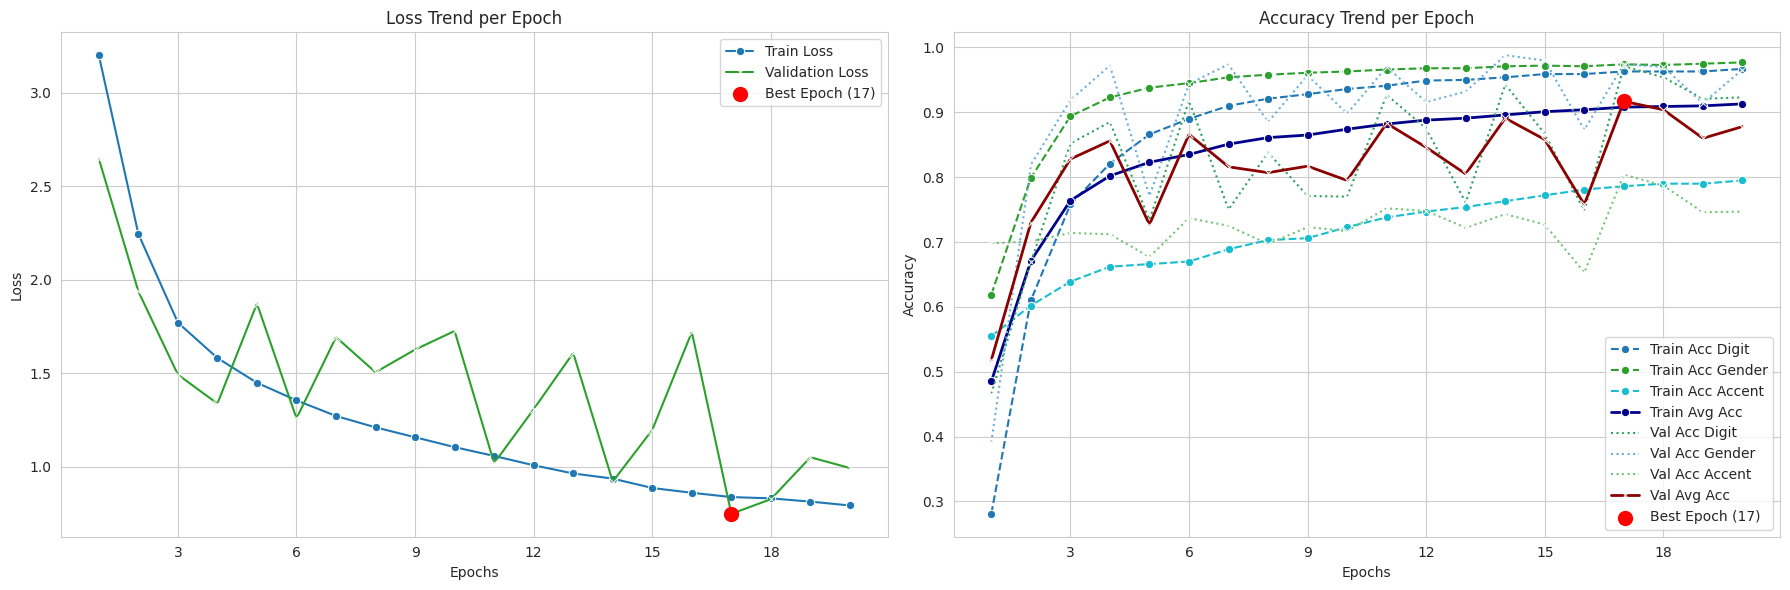

In [36]:
epochs = list(range(1, 21)) # 20 epochs

plot_training_metrics(
    epochs,
    train_loss, val_loss,
    train_acc_digit, train_acc_gender, train_acc_accent, train_avg_acc,
    val_acc_digit, val_acc_gender, val_acc_accent, val_avg_acc
)

# Information Retrieval System

The system has been built to perform a **fingerprinting** task allowing the user to interact with the system using a  **Query - by - Example** approach. In other terms :


> When the user provide an audio query as example, the system retrieves the top $K$ most similar audio of the dataset with the relative metadata, basically the spoken digit, the gender and wether the accent is german or not. It also allow the user to listen both its own audio query and the retrieved ones.


In order to build such model, the logical rappresentation of the audio data of our collection will be the Vectorial one. Once that one choose such a technique to express the intrinsic information contained in the data, the main problem is to find the optimal feture extraction approach to rappresent such data in a vector space.

In order to obtain such vectorial rappresentation, it has been tested $2$ different methodologies :
* **MFCCs** + derivatives;
* **Multi-Task 2D-CNN** as feature extractor.

In the following there will be the implementation and the evaluation of an **Audio Unimodal IR System** where the user can only interact with a QBE approach.



## Audio Unimodal IR

In [37]:
def Features_Extraction(CNN_model , MFCCS_dataloader, CNN_dataloader, device = 'cpu', is_query = False):
    """
    Extracts and caches audio features (MFCCs and CNN embeddings) from a dataset.

    This function first checks for a pre-existing `.npz` file containing the extracted
    features. If the file is not found, it iterates through the provided dataloaders
    to compute and store the features. This process includes extracting MFCCs and
    CNN-based embeddings along with their associated metadata (digit, gender, accent).
    The computed features are then saved to a file to avoid re-computation in
    subsequent runs.

    Args:
      CNN_model: The pre-trained CNN model used to generate embeddings from audio.
      MFCCS_dataloader: A PyTorch DataLoader for loading audio data specifically for MFCC extraction.
      CNN_dataloader: A PyTorch DataLoader for loading audio data for CNN embedding extraction.
      device (str, optional): The device ('cpu' or 'cuda') to perform computations on. Defaults to 'cpu'.
      is_query (bool, optional): A flag to determine the output filename, distinguishing between
                                 a full dataset and a single query. Defaults to False.

    Returns:
      A tuple containing six elements:
      - mfccs_collection (np.array): A NumPy array containing the MFCC features.
      - mfccs_metadata_collection (list): A list of dictionaries with metadata for each MFCC feature.
      - mfccs_paths (list): A list of file paths corresponding to the MFCC features.
      - cnn_embeddings (np.array): A NumPy array containing the CNN embeddings.
      - cnn_metadata (list): A list of dictionaries with metadata for each CNN embedding.
      - cnn_paths (list): A list of file paths corresponding to the CNN embeddings.
    """

    file_name = 'Audio_Feature.npz' if not is_query else 'Audio_Feature_query.npz'
    if not os.path.exists(file_name):

        # MFCCs
        mfccs_embeddings = []
        mfccs_metadata = []
        mfccs_paths = []

        for batch in tqdm(MFCCS_dataloader, desc="Extracting MFCCs Features"):
            signal, digit_label, gender_label, accent_label, transformed_signal, paths = batch
            transformed_signal = transformed_signal.to(device).numpy()

            for i in range(len(transformed_signal)):
                mfccs_embeddings.append(transformed_signal[i])
                mfccs_paths.append(paths[i])
                mfccs_metadata.append({
                    'digit': digit_label[i].item(),
                    'gender': gender_label[i].item(),
                    'accent': accent_label[i].item()
                })


        # Embedded Features
        CNN_model.eval()
        cnn_embeddings = []
        cnn_metadata = []
        cnn_paths = []

        with torch.no_grad():
            for batch in tqdm(CNN_dataloader, desc="Extracting Multi-Task CNN Embeddings"):
                signal, digit_label, gender_label, accent_label, transformed_signal, paths = batch
                transformed_signal = transformed_signal.to(device)

                # Extracts only the embeddings
                embeddings = CNN_model.get_embeddings(transformed_signal)

                # Moves to CPU and converts to numpy
                embeddings_np = embeddings.cpu().numpy()

                # Saves embeddings and metadata
                for i in range(len(embeddings_np)):
                    cnn_embeddings.append(embeddings_np[i])
                    cnn_paths.append(paths[i])
                    cnn_metadata.append({
                        'digit': digit_label[i].item(),
                        'gender': gender_label[i].item(),
                        'accent': accent_label[i].item()
                    })

        # SAVE AS .npz
        mfccs_collection, mfccs_metadata_collection = np.array(mfccs_embeddings), mfccs_metadata
        cnn_embeddings, cnn_metadata = np.array(cnn_embeddings), cnn_metadata
        np.savez(file_name,
                 mfccs_collection = mfccs_collection,
                 mfccs_metadata_collection = mfccs_metadata_collection,
                 mfccs_paths = mfccs_paths,
                 cnn_embeddings = cnn_embeddings,
                 cnn_metadata = cnn_metadata,
                 cnn_paths = cnn_paths)


    else:
        # Load
        loaded_data = np.load(file_name, allow_pickle = True)

        # Acces to the Embeddings
        mfccs_collection = loaded_data['mfccs_collection']
        mfccs_metadata_collection = loaded_data['mfccs_metadata_collection']
        mfccs_paths = loaded_data['mfccs_paths']

        cnn_embeddings = loaded_data['cnn_embeddings']
        cnn_paths = loaded_data['cnn_paths']
        cnn_metadata = loaded_data['cnn_metadata']

        loaded_data.close()

    return mfccs_collection, mfccs_metadata_collection, mfccs_paths, cnn_embeddings, cnn_metadata, cnn_paths

* **Pytorch Data Loaders set up**

In [38]:
# Parameters
N_FFT = 2048
HOP_LENGTH = 1024
N_MELS = 40
NUM_SAMPLES = 30_000
SAMPLE_RATE = 48_000
N_MFCC = 13
BATCH_SIZE = 256

device = "cuda" if torch.cuda.is_available() else "cpu"

#-------------------------------------------------#
print('Mel-Spectogramm for CNN Model Dataloaders ')
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate = SAMPLE_RATE,
                                                       n_fft = N_FFT,
                                                       hop_length = HOP_LENGTH ,
                                                       n_mels = N_MELS,
                                                       )

AudioMNIST_mel = AudioMNIST_Dataset(DATASET_PATH = '/content/AudioMNIST_clean.csv',
                                transformation = mel_spectrogram,
                                target_sample_rate = SAMPLE_RATE,
                                num_samples = NUM_SAMPLES,
                                device = device)

AudioMNIST_mel_data  = AudioMNIST_Dataset_Train_Val(DATASET_PATH = '/content/AudioMNIST_clean.csv',
                                                transformation = mel_spectrogram,
                                                target_sample_rate = SAMPLE_RATE,
                                                num_samples = NUM_SAMPLES,
                                                device = device)

AudioMNIST_mel_query  = AudioMNIST_Dataset_Train_Val(DATASET_PATH = '/content/AudioMNIST_clean.csv',
                                               transformation = mel_spectrogram,
                                               target_sample_rate = SAMPLE_RATE,
                                               num_samples = NUM_SAMPLES,
                                               device = device,
                                               split = "val")

print(f"There are {len(AudioMNIST_mel_data)} samples in the training set.")
print(f"There are {len(AudioMNIST_mel_query)} samples in the validation set.")

# DataLoaders

AudioMNIST_mel_dataloader = DataLoader(AudioMNIST_mel_data,
                                         batch_size = BATCH_SIZE,
                                         shuffle = True)

AudioMNIST_mel_queryloader = DataLoader(AudioMNIST_mel_query,
                                       batch_size = BATCH_SIZE,
                                       shuffle = True)

print(f"\nThere are {len(AudioMNIST_mel_dataloader)} batches in the training set.")
print(f"There are {len(AudioMNIST_mel_queryloader)} batches in the validation set.")

#-------------------------- MFCCs ----------------------------------------------
print('\nMFCCs Dataloaders')
mfcc_transform = T.MFCC(sample_rate = SAMPLE_RATE,
                        n_mfcc = N_MFCC,
                        melkwargs ={
                        "n_fft": N_FFT,
                        "hop_length": HOP_LENGTH,
                        "n_mels": N_MELS}
                        )

AudioMNIST_mfcc  = AudioMNIST_Dataset(DATASET_PATH = '/content/AudioMNIST_clean.csv',
                                       transformation = mfcc_transform,
                                       target_sample_rate = SAMPLE_RATE,
                                       num_samples = NUM_SAMPLES,
                                       device = device)

AudioMNIST_mfcc_data  = AudioMNIST_Dataset_Train_Val(DATASET_PATH = '/content/AudioMNIST_clean.csv',
                                                      transformation = mfcc_transform,
                                       		            target_sample_rate = SAMPLE_RATE,
                                       		            num_samples = NUM_SAMPLES,
                                       		            device = device)

AudioMNIST_mfcc_query  = AudioMNIST_Dataset_Train_Val(DATASET_PATH='/content/AudioMNIST_clean.csv',
                                                    transformation = mfcc_transform,
                                       		          target_sample_rate = SAMPLE_RATE,
                                       		          num_samples = NUM_SAMPLES,
                                       		          device = device,
                                                    split = "val")

print(f"There are {len(AudioMNIST_mfcc_data)} samples in the training set.")
print(f"There are {len(AudioMNIST_mfcc_query)} samples in the validation set.")

AudioMNIST_mfcc_dataloader = DataLoader(AudioMNIST_mfcc_data,
                                              batch_size = BATCH_SIZE,
                                              shuffle = True)

AudioMNIST_mfcc_queryloader = DataLoader(AudioMNIST_mfcc_query,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

print(f"\nThere are {len(AudioMNIST_mfcc_dataloader)} batches in the training set.")
print(f"There are {len(AudioMNIST_mfcc_queryloader)} batches in the validation set.")

Mel-Spectogramm for CNN Model Dataloaders 
There are 24000 samples in the training set.
There are 6000 samples in the validation set.

There are 94 batches in the training set.
There are 24 batches in the validation set.

MFCCs Dataloaders
There are 24000 samples in the training set.
There are 6000 samples in the validation set.

There are 94 batches in the training set.
There are 24 batches in the validation set.


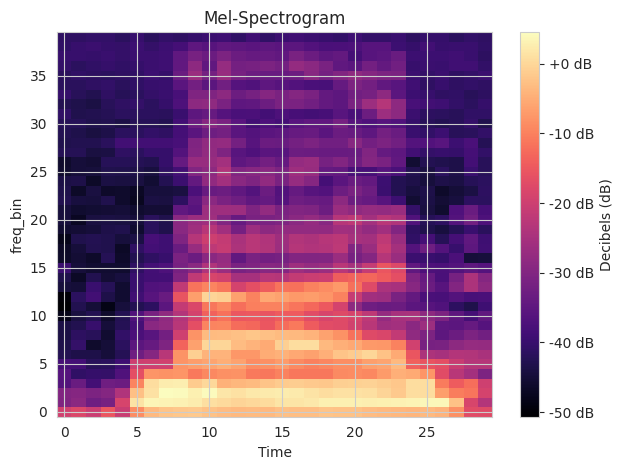

'This is the number 9, spoken by a 1, with the 0 accent'

In [39]:
# Spectogram Visualization
AudioMNIST_mel.plot_spectrogram(title = 'Mel-Spectrogram')

* **Model Weights Loading**

In [40]:
model = MultiTaskAudioMNIST()
checkpoint = torch.load('best_multitask_model_17_epoch.pth',
                        map_location=torch.device('cpu'))
checkpoint_state = checkpoint['model_state_dict']

model_state = model.state_dict()

# Check for compatibility
filtered_state = {
    k: v for k, v in checkpoint_state.items()
    if k in model_state and v.shape == model_state[k].shape
}

model_state.update(filtered_state)
model.load_state_dict(model_state, strict=False)

<All keys matched successfully>

* **Feature Extraction**

In [41]:
# Feature Extraction for documents
mfccs_collection, mfccs_metadata_collection, mfccs_paths, cnn_embeddings, cnn_metadata, cnn_paths = \
Features_Extraction(model , AudioMNIST_mfcc_dataloader, AudioMNIST_mel_dataloader, device = 'cpu')

# Feature Extraction for queries
mfccs_query_collection, mfccs_query_metadata_collection, mfccs_query_paths, cnn_query_embeddings, cnn_query_metadata, cnn_query_paths = \
Features_Extraction(model , AudioMNIST_mfcc_queryloader, AudioMNIST_mel_queryloader, device = 'cpu', is_query=True)

In [42]:
print('Mfccs vector db shape: ', mfccs_collection.shape)
print('Mfccs vector query shape: ', mfccs_query_collection.shape)
print('\nCNN vector db shape: ', cnn_embeddings.shape)
print('CNN vector query shape: ', cnn_query_embeddings.shape)

Mfccs vector db shape:  (24000, 39)
Mfccs vector query shape:  (6000, 39)

CNN vector db shape:  (24000, 512)
CNN vector query shape:  (6000, 512)


### Ground Truth Graded Relevance

Since the aim of our system consist of finding the most similar audio for a given audio query, wee need of ground truth lables to compare the results of the choosen ranking algorithms with the latter. In according to the current modellization, we must define a **Relevance Graded Score** that reflects how much the retrieved document are relevant for the i-th current query. Now, exploiting the fact that for each audio we got digit, gender and german accent labels, we can define:


* $$
\mathbf{R_{Grad}}(A, Q) = \sum_{k=1}^{N_{\text{label}}} \delta_{k}(A, Q)$$

where $\delta_k(A,Q)$ is the Kronecker delta, which returns 1 if the $k$-th label of the retrieved audio and the query match, and 0 otherwise.
Of course, since the number of labels $N_{\text{label}} > 1$ , the relevance score is graded, so one need to use a proper **Evaluation Metric** to measure how well the system rank the retrieved the audio; for this purpose the **Normalized Discounted Cumulated Gain (NDCG)** will be used.

As a possibile alternative, one might also be more restrictive about the Relevance Score computation, for instance we can consider an *informative object* (audio waveform in this case) relevant if and only if all the aforementioned lables match simultaneously between the i-th query and the j-th audio in the collection.

In this scenario, since this is a classical **Binary Relevance** case, we will consider the **Mean Reciprocal Rank (MRR)** as the proper evaluation metric to use.


The choice of these methods is motivated by the need to assess the system's ability to rank the the most similar retrieved objects in the first positions in order to gurantee a better user experience.




Such graded Relevance Score will be usefull to built the so called **Gain Vector (G)**, basically the ordered list of the ranked vectors wich contains the Relevance Score as its elements. By summing up the *gains* of the vector and considering the cumulated value until the i-th position as the new elment at the i-th position itself, we obtain the **Cumulated Gain Vector**. Finally, we can define also the **Discounted Cumulated Gain** to point out that most relevant document at the end of the ranking have lower impact and viceversa.

Since these metrics are not optimal to compare two or more different ranking alrgorithm performances, it will be necessary to define their normalized version.

In [43]:
def evaluate_ranking_results(query_metadata, ranked_metadata_per_query, graded_relevance :bool = True, MRR_at_n :int = 5):
    """
    Evaluates the performance of a ranked retrieval system based on relevance scores.

    This function calculates various metrics, including Normalized Cumulative Gain (NCG),
    Normalized Discounted Cumulative Gain (NDCG), and Mean Reciprocal Rank (MRR),
    to assess the quality of the retrieved results. Relevance is determined by
    matching metadata attributes (digit, gender, accent) between the query and the
    retrieved audio files.

    Args:
      query_metadata (list): A list of dictionaries, one for each query, containing
                             its metadata (e.g., 'digit', 'gender', 'accent').
      ranked_metadata_per_query (list): A list of lists. Each inner list contains
                                        the metadata of the retrieved items, ranked
                                        by similarity to the corresponding query.
      graded_relevance (bool, optional): If True, computes NCG and NDCG based on
                                         graded relevance scores. If False, computes
                                         MRR based on binary relevance. Defaults to True.
      MRR_at_n (int, optional): The number of top results to consider for the MRR
                                calculation. Only used when graded_relevance is False.
                                Defaults to 5.

    Returns:
      A tuple containing the evaluation results:
      - If graded_relevance is True:
        - Normalized_CG (np.array): The average Normalized Cumulative Gain over all queries.
        - Normalized_DCG (np.array): The average Normalized Discounted Cumulative Gain over all queries.
        - Gain_Vectors_ALL_queries (np.array): The relevance gain vectors for each query.
      - If graded_relevance is False:
        - MRR (float): The Mean Reciprocal Rank.
        - RR_ALL_queries (np.array): The Reciprocal Rank for each individual query.
        - None
    """
    # Graded Relevance Lists
    Gain_Vectors_ALL_queries = []
    CG_ALL_queries = []
    ICG_ALL_queries = []
    DCG_ALL_queries = []
    IDCG_ALL_queries = []

    # Reciprocal Rank Lists
    RR_ALL_queries = []

    for query_meta, ranked_metadata in zip(query_metadata, ranked_metadata_per_query):
        Gain_Vector = []

        # Labels extraction from query
        query_digit = query_meta['digit']
        query_gender = query_meta['gender']
        query_accent = query_meta['accent']

        # Calculate relevance score for each ranked element
        for audio_metadata in ranked_metadata:
            Relevance_Score = 0

            # Labels extraction from audio
            audio_digit = audio_metadata['digit']
            audio_gender = audio_metadata['gender']
            audio_accent = audio_metadata['accent']

            # Relevance Score
            if query_digit == audio_digit:
                Relevance_Score += 1
            if query_gender == audio_gender:
                Relevance_Score += 1
            if query_accent == audio_accent:
                Relevance_Score += 1

            Gain_Vector.append(Relevance_Score)

        # Cumulated Gain (CG) and Discounted Cumulated Gain (DCG) per query
        Gain_Vector = np.array(Gain_Vector)
        Ideal_Gain_Vector = np.sort(Gain_Vector)[::-1]

        CG = np.cumsum(Gain_Vector)
        ICG = np.cumsum(Ideal_Gain_Vector)

        Discounted_Gain = Gain_Vector / np.log2(np.arange(2, len(Gain_Vector) + 2))
        Discounted_Ideal_Gain = Ideal_Gain_Vector / np.log2(np.arange(2, len(Ideal_Gain_Vector) + 2))

        DCG = np.cumsum(Discounted_Gain)
        IDCG = np.cumsum(Discounted_Ideal_Gain)

        Gain_Vectors_ALL_queries.append(Gain_Vector)
        CG_ALL_queries.append(CG)
        ICG_ALL_queries.append(ICG)
        IDCG_ALL_queries.append(IDCG)
        DCG_ALL_queries.append(DCG)

    ## MRR Score at n
    if not graded_relevance:

      threshold = MRR_at_n

      for query_gain in Gain_Vectors_ALL_queries:

        MRR_Vector = np.array(query_gain[:threshold])
        indices = np.where(MRR_Vector == 3)[0]
        RR_Score = 1 / (indices[0] + 1) if  indices.size > 0 else 0.0

        RR_ALL_queries.append(RR_Score)

      RR_ALL_queries = np.array(RR_ALL_queries)

      return np.mean(RR_ALL_queries), np.array(RR_ALL_queries), None

    # Average CG, ICG, DCG, IDCG over all queries
    CG_ALL_queries = np.array(CG_ALL_queries)
    ICG_ALL_queries = np.array(ICG_ALL_queries)
    DCG_ALL_queries = np.array(DCG_ALL_queries)
    IDCG_ALL_queries = np.array(IDCG_ALL_queries)

    CG_mean = np.mean(CG_ALL_queries, axis=0)
    ICG_mean = np.mean(ICG_ALL_queries, axis=0)
    DCG_mean = np.mean(DCG_ALL_queries, axis=0)
    IDCG_mean = np.mean(IDCG_ALL_queries, axis=0)

    # Normalized Cumulative Gain & Normalized Discounted Gain
    Normalized_CG = CG_mean / ICG_mean
    Normalized_DCG = DCG_mean / IDCG_mean

    return Normalized_CG, Normalized_DCG, np.array(Gain_Vectors_ALL_queries)

### Retrieval Performance Evaluation

In [44]:
def Ranking_Function_Comparison(query_embedding, query_metadata, database_embeddings, database_metadata, k = 15):
    """
    Performs a K-Nearest Neighbors (KNN) search on a database of audio features
    and evaluates the retrieval performance using various ranking metrics.

    The function supports different distance metrics and algorithms (although currently
    it is hardcoded to 'cosine' and 'brute' force), finds the k most similar items,
    and then calculates performance scores like Normalized Discounted Cumulative Gain (NDCG)
    and Mean Reciprocal Rank (MRR).

    Args:
      query_embedding (list or array): A list of query feature embeddings.
      query_metadata (list): A list of dictionaries containing metadata for each query.
      database_embeddings (list or array): The database of feature embeddings to search.
      database_metadata (list): The metadata corresponding to each embedding in the database.
      k (int, optional): The number of nearest neighbors to retrieve. Defaults to 15.

    Returns:
      dict: A nested dictionary containing the results of the ranking process for each
            combination of ranking function and algorithm. The results include
            the indices of the retrieved items, their distances, and various
            performance metrics.
    """
    Ranking_Functions = ['cosine']
    algorithms = ['brute']      # , 'kd_tree','ball_tree']

    results = {}

    for Ranking_Function in Ranking_Functions:
        #print('Current Ranking Function: ', Ranking_Function)

        for algorithm in algorithms:
            #print(f'   Algorithm: {algorithm}')

            if Ranking_Function == 'cosine' and algorithm != 'brute':
              #print(f'     Skipping incompatible combination: {Ranking_Function} + {algorithm}')
              continue

            # KNN Algorithm
            nbrs = NearestNeighbors(n_neighbors=k, algorithm=algorithm, metric=Ranking_Function).fit(database_embeddings)
            distances, indices = nbrs.kneighbors(query_embedding)

            # Extract database metadata corresponding to indices for each query
            ranked_metadata_per_query = []
            ranked_embeddings_per_query = []

            for query_idx in range(len(query_embedding)):

                # Top k nearest elements for this query
                query_indices = indices[query_idx]

                # Extract corresponding metadata
                query_ranked_metadata = [database_metadata[idx] for idx in query_indices]
                query_ranked_embeddings = [database_embeddings[idx] for idx in query_indices]

                ranked_metadata_per_query.append(query_ranked_metadata)
                ranked_embeddings_per_query.append(query_ranked_embeddings)

            # Evaluation
            Normalized_CG, Normalized_DCG, Gain_Vectors = evaluate_ranking_results(query_metadata,
                                                                                   ranked_metadata_per_query,
                                                                                   graded_relevance = True)

            MRR, RR_ALL_queries, _ = evaluate_ranking_results(query_metadata,
                                                              ranked_metadata_per_query,
                                                              graded_relevance = False,
                                                              MRR_at_n = k)

            # Save results
            key = f"{Ranking_Function}_{algorithm}"
            results[key] = {
                'indices': indices,
                'distances': distances,
                'ranked_metadata': ranked_metadata_per_query,
                'ranked_embeddings': ranked_embeddings_per_query,
                'Normalized_CG': Normalized_CG,
                'Normalized_DCG': Normalized_DCG,
                'Gain_Vectors': Gain_Vectors,
                'MRR': MRR
            }

    return results

In [45]:
for k in [1, 2, 3, 5]:
  eval_results_mfccs = Ranking_Function_Comparison(query_embedding = mfccs_query_collection,
                                                  query_metadata = mfccs_query_metadata_collection,
                                                  database_embeddings = mfccs_collection,
                                                  database_metadata = mfccs_metadata_collection,
                                                  k = k)

  eval_results_cnn = Ranking_Function_Comparison(query_embedding = cnn_query_embeddings,
                                                  query_metadata = cnn_query_metadata,
                                                  database_embeddings = cnn_embeddings,
                                                  database_metadata = cnn_metadata,
                                                  k = k)

  print(f'MRR CNN @ {k}: {eval_results_cnn["cosine_brute"]["MRR"].round(2)}')
  print(f'MRR MFCCs @ {k}: {eval_results_mfccs["cosine_brute"]["MRR"].round(2)}')

MRR CNN @ 1: 0.87
MRR MFCCs @ 1: 0.91
MRR CNN @ 2: 0.9
MRR MFCCs @ 2: 0.93
MRR CNN @ 3: 0.91
MRR MFCCs @ 3: 0.93
MRR CNN @ 5: 0.91
MRR MFCCs @ 5: 0.93


### Normalized DCG Curves

In [46]:
def print_ranking_summary(results_dict, Feature_Extraction_technique :str):
    """
    Print a text summary of the ranking performance
    """
    print("="*60)
    print(f"RANKING PERFORMANCE SUMMARY - {Feature_Extraction_technique}")
    print("="*60)

    metrics_data = {}
    for func_name, data in results_dict.items():
        ndcg_values = data['Normalized_DCG']
        metrics_data[func_name] = {
            'Mean': np.mean(ndcg_values),
            'Std': np.std(ndcg_values),
            'NDCG@1': ndcg_values[0] if len(ndcg_values) > 0 else ndcg_values[-1],
            'NDCG@2': ndcg_values[1] if len(ndcg_values) > 1 else ndcg_values[-1],
            'NDCG@3': ndcg_values[2] if len(ndcg_values) > 2 else ndcg_values[-1],
            'NDCG@5': ndcg_values[4] if len(ndcg_values) > 4 else ndcg_values[-1],
            'NDCG@10': ndcg_values[9] if len(ndcg_values) > 9 else ndcg_values[-1]
        }

    # Sort by mean performance
    sorted_functions = sorted(metrics_data.items(), key=lambda x: x[1]['Mean'], reverse=True)

    print("\nRANKING BY OVERALL PERFORMANCE:")
    for i, (func_name, metrics) in enumerate(sorted_functions):
        print(f"{i+1}. {func_name.replace('_', ' ').title()}")
        print(f"   Mean NDCG: {metrics['Mean']:.4f} (±{metrics['Std']:.4f})")
        print(f"   NDCG@1: {metrics['NDCG@1']:.4f} | NDCG@2: {metrics['NDCG@2']:.4f}")
        print(f"   NDCG@3: {metrics['NDCG@3']:.4f} | NDCG@5: {metrics['NDCG@5']:.4f}")
        print(f"   Stability: {'High' if metrics['Std'] < 0.01 else 'Medium' if metrics['Std'] < 0.02 else 'Low'}")
        print()

    # Best function recommendation
    best_func = sorted_functions[0][0]
    print(f"🏆 RECOMMENDED: {best_func.replace('_', ' ').title()}")
    print(f"   Highest overall performance with good stability")
    print("="*60)

In [47]:
def visualize_ndcg_results(results_cnn: dict, results_mfcc: dict, figsize=(10, 6), save_path=None):
    """
    Plots the NDCG curves for the ideal case, CNN, and MFCC methods.

    This function generates a single plot to compare the Normalized Discounted
    Cumulative Gain (NDCG) performance of two different feature extraction methods
    (a CNN and MFCCs) against an ideal scenario. It's useful for visualizing
    the ranking quality of the retrieval system.

    Parameters
    ----------
    results_cnn : dict
        A dictionary containing the NDCG results for the CNN method.
        Expected format: {"Normalized_DCG": array_like}
    results_mfcc : dict
        A dictionary containing the NDCG results for the MFCC method.
        Expected format: {"Normalized_DCG": array_like}
    figsize : tuple
        The size of the figure.
    save_path : str, optional
        If specified, the plot will be saved to this path.

    """
    plt.figure(figsize=figsize, facecolor='white')

    # CNN
    ndcg_cnn = np.array(results_cnn['cosine_brute']["Normalized_DCG"])
    x_cnn = np.arange(1, len(ndcg_cnn) + 1)
    plt.plot(x_cnn, ndcg_cnn, label="CNN", color="blue",marker = '^', linewidth=2)

    # MFCC
    ndcg_mfcc = np.array(results_mfcc['cosine_brute']["Normalized_DCG"])
    x_mfcc = np.arange(1, len(ndcg_mfcc) + 1)
    plt.plot(x_mfcc, ndcg_mfcc, label="MFCC", color="red", marker = 'o', linewidth=2)

    # Ideal Curve (y=1 line with max length of the two methods)
    max_len = max(len(ndcg_cnn), len(ndcg_mfcc))
    x_ideal = np.arange(1, max_len + 1)
    plt.plot(x_ideal, np.ones_like(x_ideal), label="Ideal Case", color="green", linewidth=2, linestyle="--")

    # Layout
    plt.xlabel("Rank Position", fontsize=12)
    plt.ylabel("NDCG Score", fontsize=12)
    plt.ylim(0.90, 1.01)
    plt.xticks(np.arange(1, max_len + 1))

    plt.title("NDCG Comparison: Ideal vs CNN vs MFCC", fontsize=14, fontweight="bold")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Plot saved to {save_path}")

    plt.show()

In [48]:
K = 10

print('MFFCs...')
eval_results_mfccs = Ranking_Function_Comparison(query_embedding = mfccs_query_collection,
                                                query_metadata = mfccs_query_metadata_collection,
                                                database_embeddings = mfccs_collection,
                                                database_metadata = mfccs_metadata_collection,
                                                k = K)

print('\nCNN Embedding...')
eval_results_cnn = Ranking_Function_Comparison(query_embedding = cnn_query_embeddings,
                                                query_metadata = cnn_query_metadata,
                                                database_embeddings = cnn_embeddings,
                                                database_metadata = cnn_metadata,
                                                k = K)

MFFCs...

CNN Embedding...


Plot saved to NDCG_Curves


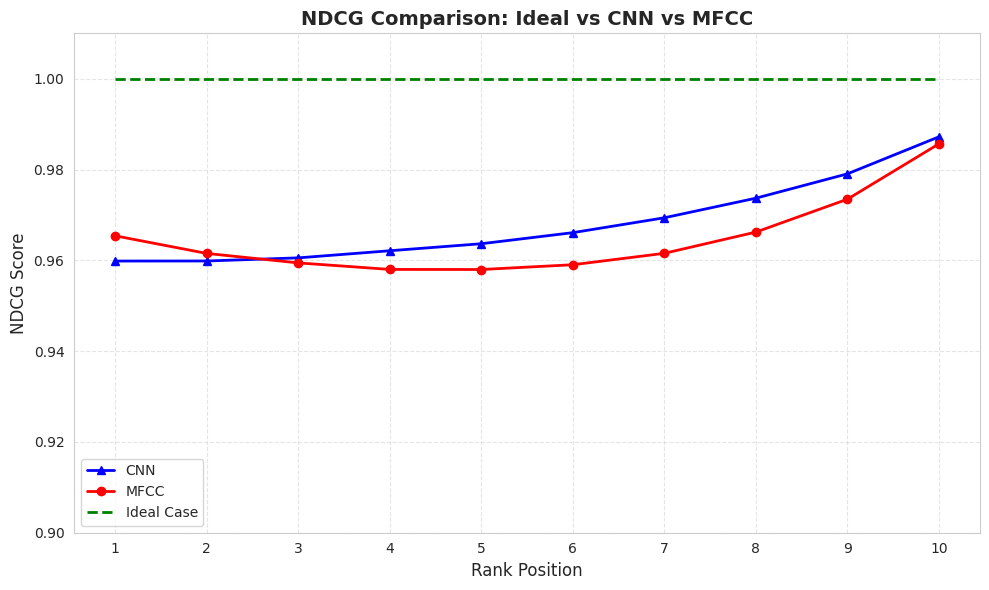

In [49]:
# MFCCs
visualize_ndcg_results(eval_results_cnn, eval_results_mfccs, save_path = 'NDCG_Curves')

In [50]:
print_ranking_summary(eval_results_mfccs, Feature_Extraction_technique = 'MFCCs + Deltas')
print_ranking_summary(eval_results_cnn, Feature_Extraction_technique = 'CNN Embedding')

RANKING PERFORMANCE SUMMARY - MFCCs + Deltas

RANKING BY OVERALL PERFORMANCE:
1. Cosine Brute
   Mean NDCG: 0.9648 (±0.0083)
   NDCG@1: 0.9654 | NDCG@2: 0.9615
   NDCG@3: 0.9594 | NDCG@5: 0.9580
   Stability: High

🏆 RECOMMENDED: Cosine Brute
   Highest overall performance with good stability
RANKING PERFORMANCE SUMMARY - CNN Embedding

RANKING BY OVERALL PERFORMANCE:
1. Cosine Brute
   Mean NDCG: 0.9681 (±0.0088)
   NDCG@1: 0.9598 | NDCG@2: 0.9599
   NDCG@3: 0.9605 | NDCG@5: 0.9637
   Stability: High

🏆 RECOMMENDED: Cosine Brute
   Highest overall performance with good stability


### IR System Implementation

 In this section we only want to set the correct workflow to check whether the system works or not. For this reason we will define again the Datasets and their relative DataLoader to run again the feature extraction function without using the `shuffule = True` parameter for the dataloaders, by doing so we preserve the ordering and thus the indices matching between the original dataset and the extracted features obtained. Since the splitting between train (data colleciton) and validaiton (test audio query) is still the same, we do not loose disjointness condition, which is foundamental to avoid the so called data leakage.

#### Functions and Settings

In [51]:
# Fixed Parameters
N_FFT = 2048
HOP_LENGTH = 1024
N_MELS = 40
NUM_SAMPLES = 30_000
SAMPLE_RATE = 48_000
N_MFCC = 13
BATCH_SIZE = 256

device = "cuda" if torch.cuda.is_available() else "cpu"

# Possible Transformation
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate = SAMPLE_RATE,
                                                      n_fft = N_FFT,
                                                      hop_length = HOP_LENGTH ,
                                                      n_mels = N_MELS,
                                                      )

mfcc_transform = T.MFCC(sample_rate = SAMPLE_RATE,
                      n_mfcc = N_MFCC,
                      melkwargs ={
                      "n_fft": N_FFT,
                      "hop_length": HOP_LENGTH,
                      "n_mels": N_MELS}
                      )

# Dataset Colleciton
AudioMNIST_mel_collection  = AudioMNIST_Dataset_Train_Val(DATASET_PATH = '/content/AudioMNIST_clean.csv',
                                                transformation = mel_spectrogram,
                                                target_sample_rate = SAMPLE_RATE,
                                                num_samples = NUM_SAMPLES,
                                                device = device)

AudioMNIST_mfcc_collection  = AudioMNIST_Dataset_Train_Val(DATASET_PATH = '/content/AudioMNIST_clean.csv',
                                                transformation = mfcc_transform,
                                                target_sample_rate = SAMPLE_RATE,
                                                num_samples = NUM_SAMPLES,
                                                device = device)

# DataLoaders
AudioMNIST_mels_dataloader = DataLoader(AudioMNIST_mel_collection,
                                         batch_size = BATCH_SIZE,
                                         shuffle = False)

AudioMNIST_mfccs_dataloader = DataLoader(AudioMNIST_mfcc_collection,
                                         batch_size = BATCH_SIZE,
                                         shuffle = False)

# Model Upload
model = MultiTaskAudioMNIST()
checkpoint = torch.load('best_multitask_model_17_epoch.pth',
                        map_location=torch.device('cpu'))
checkpoint_state = checkpoint['model_state_dict']

model_state = model.state_dict()

# Check for compatibility
filtered_state = {
    k: v for k, v in checkpoint_state.items()
    if k in model_state and v.shape == model_state[k].shape
}

model_state.update(filtered_state)
model.load_state_dict(model_state, strict=False)

<All keys matched successfully>

In [52]:
def Features_Extraction_IR(CNN_model , MFCCS_dataloader, CNN_dataloader, device = 'cpu', is_query = False):
    """
    Extracts and caches audio features (MFCCs and CNN embeddings) from a dataset.

    This function first checks if a .npz file with the pre-extracted features
    already exists. If it does, it loads the data to save time. Otherwise, it
    iterates through the provided dataloaders to extract MFCCs and CNN embeddings,
    along with their metadata, and saves them to a file for future use.

    Args:
      CNN_model: The convolutional neural network model used to generate embeddings.
      MFCCS_dataloader: A dataloader that provides batches of audio data for MFCC extraction.
      CNN_dataloader: A dataloader that provides batches of audio data for CNN embedding extraction.
      device (str, optional): The device to use for computations ('cpu' or 'cuda').
                              Defaults to 'cpu'.
      is_query (bool, optional): A flag to determine the output filename.
                                 Defaults to False.

    Returns:
      A tuple containing six elements:
      - mfccs_collection (np.array): A NumPy array of MFCC features.
      - mfccs_metadata_collection (list): A list of dictionaries containing metadata for each MFCC feature.
      - mfccs_paths (list): A list of file paths corresponding to the MFCC features.
      - cnn_embeddings (np.array): A NumPy array of CNN embeddings.
      - cnn_metadata (list): A list of dictionaries containing metadata for each CNN embedding.
      - cnn_paths (list): A list of file paths corresponding to the CNN embeddings.
    """

    file_name = 'Audio_Feature_IR.npz' if not is_query else 'Audio_Feature_query_IR.npz'
    if not os.path.exists(file_name):

        # MFCCs
        mfccs_embeddings = []
        mfccs_metadata = []
        mfccs_paths = []

        for batch in tqdm(MFCCS_dataloader, desc="Extracting MFCCs Features"):
            signal, digit_label, gender_label, accent_label, transformed_signal, paths = batch
            transformed_signal = transformed_signal.to(device).numpy()

            for i in range(len(transformed_signal)):
                mfccs_embeddings.append(transformed_signal[i])
                mfccs_paths.append(paths[i])
                mfccs_metadata.append({
                    'digit': digit_label[i].item(),
                    'gender': gender_label[i].item(),
                    'accent': accent_label[i].item()
                })


        # Embedded Features
        CNN_model.eval()
        cnn_embeddings = []
        cnn_metadata = []
        cnn_paths = []
        with torch.no_grad():
            for batch in tqdm(CNN_dataloader, desc="Extracting Multi-Task CNN Embeddings"):
                signal, digit_label, gender_label, accent_label, transformed_signal, paths = batch
                transformed_signal = transformed_signal.to(device)

                # Extract embeddings only
                embeddings = CNN_model.get_embeddings(transformed_signal)

                # Move to CPU and convert to numpy
                embeddings_np = embeddings.cpu().numpy()

                # Save embeddings and metadata
                for i in range(len(embeddings_np)):
                    cnn_embeddings.append(embeddings_np[i])
                    cnn_paths.append(paths[i])
                    cnn_metadata.append({
                        'digit': digit_label[i].item(),
                        'gender': gender_label[i].item(),
                        'accent': accent_label[i].item()
                    })

        # SAVE AS .npz
        mfccs_collection, mfccs_metadata_collection = np.array(mfccs_embeddings), mfccs_metadata
        cnn_embeddings, cnn_metadata = np.array(cnn_embeddings), cnn_metadata
        np.savez(file_name,
                 mfccs_collection = mfccs_collection,
                 mfccs_metadata_collection = mfccs_metadata_collection,
                 mfccs_paths = mfccs_paths,
                 cnn_embeddings = cnn_embeddings,
                 cnn_metadata = cnn_metadata,
                 cnn_paths = cnn_paths)


    else:
        #print(f"Uploading Embeddings and metadata from '{file_name}'.")
        # Load them back
        loaded_data = np.load(file_name, allow_pickle = True)
        #print("\nKeys in the .npz file:", loaded_data.files)


        # Access to the Embeddings
        mfccs_collection = loaded_data['mfccs_collection']
        mfccs_metadata_collection = loaded_data['mfccs_metadata_collection']
        mfccs_paths = loaded_data['mfccs_paths']

        cnn_embeddings = loaded_data['cnn_embeddings']
        cnn_metadata = loaded_data['cnn_metadata']
        cnn_paths = loaded_data['cnn_paths']

        loaded_data.close()

    return mfccs_collection, mfccs_metadata_collection, mfccs_paths, cnn_embeddings, cnn_metadata, cnn_paths

In [53]:
# Extracting matched Feature vector
mfccs_collection, mfccs_metadata_collection, mfccs_paths, cnn_embeddings, cnn_metadata, cnn_paths = \
  Features_Extraction_IR(model , AudioMNIST_mfccs_dataloader, AudioMNIST_mels_dataloader, device = 'cpu')

In [54]:
# Check if the indices match
index = 42

signal, digit_label, gender_label, accent_label, transformed_signal, _ = AudioMNIST_mel_collection[index]
print(digit_label, gender_label, accent_label)

signal, digit_label, gender_label, accent_label, transformed_signal, _ = AudioMNIST_mfcc_collection[index]
print(digit_label, gender_label, accent_label)


print(cnn_metadata[index])
print(mfccs_metadata_collection[index])

tensor(1) tensor(1) tensor(0)
tensor(1) tensor(1) tensor(0)
{'digit': 1, 'gender': 1, 'accent': 0}
{'digit': 1, 'gender': 1, 'accent': 0}


In [55]:
def Formatting_Output(audio_query_index: int, AudioMNIST_query: AudioMNIST_Dataset_Train_Val, AudioMNIST_collection:  AudioMNIST_Dataset_Train_Val, eval_results):
  """
  Formats and prints the output of the Information Retrieval system.

  This function presents the user query audio, the retrieved audio files, and
  the performance metrics of the retrieval process in a clear, formatted manner.

  Args:
    audio_query_index (int): The index of the audio file used as the query.
    AudioMNIST_query (AudioMNIST_Dataset_Train_Val): The dataset object for the query audio.
    AudioMNIST_collection (AudioMNIST_Dataset_Train_Val): The dataset object for the audio collection.
    eval_results (dict): A dictionary containing the evaluation results, including
                         retrieved indices and performance metrics.
  """

  # ----------- Formatting Output ---------------
  print('-'*10, ' User Query ','-'*10,'\n')

  AudioMNIST_query.Play_Audio(index = audio_query_index)

  print('\n','-'*10, ' Retrieved Audio ','-'*10)

  retrived_indices = eval_results['cosine_brute']['indices'][0].tolist()
  for retrived_idx in retrived_indices:

    print(f'\n{retrived_indices.index(retrived_idx) + 1}.\n')

    AudioMNIST_collection.Play_Audio(index = retrived_idx)

  print('\n','-'*10, ' Retrieval Performances ','-'*10,'\n')

  DCG_evaluation = eval_results['cosine_brute']['Normalized_DCG']
  MRR_evaluaiton = eval_results['cosine_brute']['MRR']
  print(f'Normalized DCG: {DCG_evaluation.round(2)}')
  print(f'MRR: {MRR_evaluaiton.round(2)}')

  return eval_results

#### Main Function - IR Core

In [56]:
def IR_System_Core(audio_query_index: int, feature_extractor: str, model: MultiTaskAudioMNIST, K = 5, DATASET_PATH: str = '/content/AudioMNIST_clean.csv' ):
  """
  Executes the core of an Information Retrieval (IR) system for audio.

  This function processes an audio query, extracts features using a specified method
  (either MFCCs or a CNN), and then performs a K-Nearest Neighbors (KNN) search
  to find the most similar audio files in a pre-computed collection.

  Args:
    audio_query_index (int): The index of the audio file to use as the query.
                             Must be an integer between 0 and 5999.
    feature_extractor (str): The method for feature extraction. Can be 'mfccs' or 'cnn'.
    model (MultiTaskAudioMNIST): The pre-trained model used for CNN feature extraction.
    K (int, optional): The number of nearest neighbors to retrieve. Defaults to 5.
    DATASET_PATH (str, optional): The path to the AudioMNIST dataset file.
                                  Defaults to '/content/AudioMNIST_clean.csv'.

  Returns:
    dict: The evaluation results of the ranking function, including metrics like
          MRR@K and NDCG@K.
  """

  # Error Handling
  if not (0 <= audio_query_index <= 5999):
    raise ValueError("audio_query_index must be an integer included in [0,5999].")

  valid_feature_extractors = ['mfccs', 'cnn']
  if feature_extractor not in valid_feature_extractors:
    raise ValueError(f"feature_extractor must be: {valid_feature_extractors}.")

  # Fixed Parameters
  N_FFT = 2048
  HOP_LENGTH = 1024
  N_MELS = 40
  NUM_SAMPLES = 30_000
  SAMPLE_RATE = 48_000
  N_MFCC = 13
  BATCH_SIZE = 256

  device = "cuda" if torch.cuda.is_available() else "cpu"

  # Possible Transformations
  mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate = SAMPLE_RATE,
                                                         n_fft = N_FFT,
                                                         hop_length = HOP_LENGTH ,
                                                         n_mels = N_MELS,
                                                         )

  mfcc_transform = T.MFCC(sample_rate = SAMPLE_RATE,
                          n_mfcc = N_MFCC,
                          melkwargs ={
                          "n_fft": N_FFT,
                          "hop_length": HOP_LENGTH,
                          "n_mels": N_MELS}
                          )


  # Feature Extraction for both collection
  mfccs_collection, mfccs_metadata_collection, mfccs_paths, cnn_embeddings, cnn_metadata, cnn_paths = \
  Features_Extraction_IR(model , AudioMNIST_mfcc_dataloader, AudioMNIST_mel_dataloader, device = 'cpu')

  # Reference collection dataset
  AudioMNIST_collection = AudioMNIST_Dataset_Train_Val(DATASET_PATH,
                                                       transformation = mfcc_transform,
                                                       target_sample_rate = SAMPLE_RATE,
                                                       num_samples = NUM_SAMPLES,
                                                       device = device,
                                                       )


  # ------------ QUERY MANIPULATION ---------------------

  # Audio Test Query
  if feature_extractor == 'mfccs':
    AudioMNIST_query  = AudioMNIST_Dataset_Train_Val(DATASET_PATH,
                                                     transformation = mfcc_transform,
                                                     target_sample_rate = SAMPLE_RATE,
                                                     num_samples = NUM_SAMPLES,
                                                     device = device,
                                                     split = "val")

    signal, digit_label, gender_label, accent_label, transformed_signal, _ = AudioMNIST_query[audio_query_index]

    query_metadata_mffcs = [{'digit': digit_label, 'gender': gender_label, 'accent': accent_label}]
    query_mffcs = [transformed_signal.numpy()]

    # Ranking KNN with Cosine Similarity + Performance Evaluation

    eval_results = Ranking_Function_Comparison(query_embedding = query_mffcs,
                                               query_metadata = query_metadata_mffcs,
                                               database_embeddings = mfccs_collection,
                                               database_metadata = mfccs_metadata_collection,
                                               k = K)

  elif feature_extractor == 'cnn':

    AudioMNIST_query = AudioMNIST_Dataset_Train_Val(DATASET_PATH='/content/AudioMNIST_clean.csv',
                                                     transformation = mel_spectrogram,
                                                     target_sample_rate = SAMPLE_RATE,
                                                     num_samples = NUM_SAMPLES,
                                                     device = device,
                                                     split = "val")

    signal, digit_label, gender_label, accent_label, transformed_signal, _ = AudioMNIST_query[audio_query_index]

    model.eval()
    with torch.no_grad():
      query_feature_extracted = model.get_embeddings(transformed_signal.unsqueeze(0))
      query_cnn = [query_feature_extracted.squeeze().cpu().numpy()]

    cnn_query_metadata = [{'digit': digit_label, 'gender': gender_label, 'accent': accent_label}]

    # Ranking KNN + Cosine Similarity + Performance Evaluation

    eval_results = Ranking_Function_Comparison(query_embedding = query_cnn,
                                               query_metadata = cnn_query_metadata,
                                               database_embeddings = cnn_embeddings,
                                               database_metadata = cnn_metadata,
                                               k = K)



  # Output Format
  Formatting_Output(audio_query_index , AudioMNIST_query, AudioMNIST_collection, eval_results)



  return eval_results

In [57]:
# Select the index to submit a query (0-5999)
audio_query_index = 10

In [58]:
%%time
try:
  cnn_retrieval_results = IR_System_Core(audio_query_index, feature_extractor = 'cnn', model = model, K = 3)
except Exception as e:
  print(e)

----------  User Query  ---------- 



Caption: This is the number 0, spoken by a male, with the german accent.

 ----------  Retrieved Audio  ----------

1.



Caption: This is the number 0, spoken by a male, with the german accent.

2.



Caption: This is the number 0, spoken by a male, with the german accent.

3.



Caption: This is the number 0, spoken by a male, with the german accent.

 ----------  Retrieval Performances  ---------- 

Normalized DCG: [1. 1. 1.]
MRR: 1.0
CPU times: user 566 ms, sys: 60.8 ms, total: 627 ms
Wall time: 612 ms


In [59]:
%%time
try:
  mfccs_retrieval_results = IR_System_Core(audio_query_index, feature_extractor = 'mfccs', model = model, K = 3)
except Exception as e:
  print(e)

----------  User Query  ---------- 



Caption: This is the number 0, spoken by a male, with the german accent.

 ----------  Retrieved Audio  ----------

1.



Caption: This is the number 0, spoken by a male, with the german accent.

2.



Caption: This is the number 0, spoken by a male, with the german accent.

3.



Caption: This is the number 0, spoken by a male, with the german accent.

 ----------  Retrieval Performances  ---------- 

Normalized DCG: [1. 1. 1.]
MRR: 1.0
CPU times: user 567 ms, sys: 33 ms, total: 600 ms
Wall time: 546 ms


# Gradio API

After building and testing the system, the next step is to make it accessible to external users who are not necessarily experts in the field. To this end, a graphical interface  based on **Gradio** has been implemented, allowing access to the system's functionality through an intuitive web application. The interface allows users to specify search parameters through interactive controls: a **slider** to select the audio query index (range 0-5999), a **radio button** to choose the feature extraction method (MFCC or CNN), and another **slider** to set the $K$ value of the most similar neighbors to retrieve.

## Gradio Function

In [60]:
def get_audio_data(dataset, index: int, sample_rate: int = 48000):
    """
    Extracts an audio sample from the dataset and prepares it for Gradio.

    Args:
      dataset: The AudioMNIST dataset object.
      index (int): The index of the audio sample to retrieve.
      sample_rate (int, optional): The target sample rate. Defaults to 48000.

    Returns:
      tuple: A tuple containing the sample rate and the audio signal as a
             NumPy array of type float32.
    """
    try:
        # Retrieve the signal and labels from the dataset
        signal, digit, gender, accent, transformed_signal, _ = dataset[index]

        # Convert the torch tensor to a NumPy array if necessary
        if hasattr(signal, 'numpy'):
            audio_array = signal.numpy()
        else:
            audio_array = signal

        # Squeeze the array if it has a channel dimension
        if len(audio_array.shape) > 1:
            audio_array = audio_array.squeeze()

        return (sample_rate, audio_array.astype(np.float32))

    except Exception as e:
        print(f"Audio extraction error at index {index}: {e}")
        return (sample_rate, np.zeros(1000, dtype=np.float32))


def format_results(eval_results, query_index, feature_type, AudioMNIST_query, AudioMNIST_collection):
    """
    Formats the retrieval results into a human-readable text output.

    This function structures the output to show details of the query,
    the retrieved audio files, and the retrieval performance metrics.

    Args:
      eval_results (dict): A dictionary containing the evaluation results.
      query_index (int): The index of the audio query.
      feature_type (str): The type of features used (e.g., 'mfccs', 'cnn').
      AudioMNIST_query (Dataset): The dataset for the query.
      AudioMNIST_collection (Dataset): The dataset used as the collection.

    Returns:
      str: A formatted string containing all the results.
    """
    output = []

    # ────────── User Query ──────────
    output.append("─" * 10 + " User Query " + "─" * 10)
    output.append("")
    output.append(f"Query Audio Index: {query_index}")
    output.append(f"Feature Extractor: {feature_type}")

    if AudioMNIST_query:
        try:
            signal, digit, gender, accent, transformed_signal, _ = AudioMNIST_query[query_index]
            output.append(f"Digit: {digit} | Gender: {gender} | Accent: {accent}")
        except:
            pass

    # ────────── Retrieved Audio ──────────
    output.append("\n" + "─" * 10 + " Retrieved Audio " + "─" * 10)

    if 'cosine_brute' in eval_results and 'indices' in eval_results['cosine_brute']:
        retrieved_indices = eval_results['cosine_brute']['indices'][0].tolist()
        distances = eval_results['cosine_brute'].get('distances', [None])[0]

        for i, idx in enumerate(retrieved_indices):
            output.append(f"\n{i + 1}.")
            output.append(f"Audio Index: {idx}")

            if distances is not None and i < len(distances):
                similarity = 1 - distances[i]
                output.append(f"Similarity: {similarity:.4f}")

            if AudioMNIST_collection:
                try:
                    signal, digit, gender, accent, transformed_signal, _ = AudioMNIST_collection[idx]
                    output.append(f"Digit: {digit} | Gender: {gender} | Accent: {accent}")
                except:
                    pass

    # ────────── Retrieval Performances ──────────
    output.append("\n" + "─" * 10 + " Retrieval Performance " + "─" * 10)
    output.append("")

    if 'cosine_brute' in eval_results:
        cosine_results = eval_results['cosine_brute']

        if 'Normalized_DCG' in cosine_results:
            dcg = cosine_results['Normalized_DCG']
            output.append(f"Normalized DCG: {np.round(dcg, 2)}")

        if 'MRR' in cosine_results:
            mrr = cosine_results['MRR']
            output.append(f"MRR: {np.round(mrr, 2)}")

    return "\n".join(output)


def run_ir_search(audio_index, feature_type, k_value):
    """
    Main function to run the Information Retrieval (IR) search.

    This function sets up the datasets and feature transformations, calls the
    core IR system function, formats the results, and prepares the output
    for the Gradio interface.

    Args:
      audio_index (int): The index of the audio query.
      feature_type (str): The type of feature extractor to use ('mfccs' or 'cnn').
      k_value (int): The number of neighbors to retrieve.

    Returns:
      tuple: A tuple containing status message, results text, query audio,
             and the top 5 retrieved audio files.
    """
    try:
        # FIXED PARAMETERS
        DATASET_PATH = '/content/AudioMNIST_clean.csv'
        SAMPLE_RATE = 48000
        NUM_SAMPLES = 30000

        # Transformations
        mfcc_transform = torchaudio.transforms.MFCC(
            sample_rate=SAMPLE_RATE,
            n_mfcc=13,
            melkwargs={"n_fft": 2048, "hop_length": 1024, "n_mels": 40}
        )

        # Load datasets
        AudioMNIST_query = AudioMNIST_Dataset_Train_Val(
            DATASET_PATH,
            transformation=mfcc_transform,
            target_sample_rate=SAMPLE_RATE,
            num_samples=NUM_SAMPLES,
            device='cpu',
            split="val"
        )

        AudioMNIST_collection = AudioMNIST_Dataset_Train_Val(
            DATASET_PATH,
            transformation=mfcc_transform,
            target_sample_rate=SAMPLE_RATE,
            num_samples=NUM_SAMPLES,
            device='cpu',
            split="train"
        )

        # ===== IR_System_Core =====
        eval_results = IR_System_Core(
            audio_query_index=audio_index,
            feature_extractor=feature_type,
            model=model,
            K=k_value,
            DATASET_PATH=DATASET_PATH
        )

        # Format results
        results_text = format_results(
            eval_results, audio_index, feature_type,
            AudioMNIST_query, AudioMNIST_collection
        )

        # Extract query audio
        query_audio = get_audio_data(AudioMNIST_query, audio_index, SAMPLE_RATE)

        retrieved_audios = []
        if 'cosine_brute' in eval_results:
            indices = eval_results['cosine_brute']['indices'][0].tolist()
            for i, idx in enumerate(indices[:5]):
                audio = get_audio_data(AudioMNIST_collection, idx, SAMPLE_RATE)
                retrieved_audios.append(audio)

        # Show "None" if less than 5 results are found
        while len(retrieved_audios) < 5:
            retrieved_audios.append(None)

        status = f"✅ Search completed! K={k_value} results found"

        return status, results_text, query_audio, *retrieved_audios

    except Exception as e:
        error_msg = f"❌ Error: {str(e)}"
        return error_msg, "", None, None, None, None, None, None


# ===============================================
# GRADIO INTERFACE
# ===============================================

def create_ir_interface():
    """
    Creates the Gradio interface for the audio Information Retrieval system.

    The interface consists of a search parameters column with sliders and
    radio buttons, and a results column with text boxes and audio players
    for the query and the top retrieved audios.

    Returns:
      gr.Blocks: The Gradio interface block.
    """

    with gr.Blocks(title="🎵 Audio IR System") as demo:

        gr.Markdown("# 🎵 Audio Information Retrieval System")

        with gr.Row():
            # INPUTS
            with gr.Column(scale=1):
                gr.Markdown("### Search Parameters")

                audio_idx = gr.Slider(
                    0, 5999, 0, step=1,
                    label="Audio Query Index"
                )

                feature_type = gr.Radio(
                    ['mfccs', 'cnn'],
                    value='mfccs',
                    label="Feature Extractor"
                )

                k_value = gr.Slider(
                    1, 10, 5, step=1,
                    label="K Neighbors"
                )

                search_btn = gr.Button("🔍 Start Search", variant="primary")

            # OUTPUTS
            with gr.Column(scale=2):
                status = gr.Textbox(label="Status", interactive=False)
                results = gr.Textbox(label="Results", lines=15, interactive=False)

                # AUDIO PLAYERS
                gr.Markdown("### 🔊 Audio")
                query_audio = gr.Audio(label="🎵 Query Audio")

                gr.Markdown("#### Top 5 Results:")
                audio1 = gr.Audio(label="1st Result")
                audio2 = gr.Audio(label="2nd Result")
                audio3 = gr.Audio(label="3rd Result")
                audio4 = gr.Audio(label="4th Result")
                audio5 = gr.Audio(label="5th Result")

        # EVENTS
        search_btn.click(
            fn=run_ir_search,
            inputs=[audio_idx, feature_type, k_value],
            outputs=[status, results, query_audio, audio1, audio2, audio3, audio4, audio5]
        )

    return demo

## API-Demo

In [61]:
print("🚀 Caricamento Sistema IR Audio...")
print("🌐 Avvio interfaccia Gradio...")

# Start Demo
demo = create_ir_interface()
demo.launch(share=True)

🚀 Caricamento Sistema IR Audio...
🌐 Avvio interfaccia Gradio...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://28886776ae09bff864.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [62]:
demo.close()

Closing server running on port: 7860


# Execution Time

The execution time is evaluated considering the Features already extracted, the CNN already trained and the CPU as device.

In [63]:
# Colab Execution time
end_time = time.time()
total_time = end_time - start_time
print(f"Execution Time: {total_time:.2f} sec")

Execution Time: 212.43 sec
